<a href="https://colab.research.google.com/github/GFDRR/disaster-fcv-colocation-mapping/blob/master/examples/demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setup

Note: after running the first cell, you will be prompted to restart the session. Hit `Restart session` and continue running the rest of the cells.

In [ ]:
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ dfcv-colocation-mapping==0.4.9

In [1]:
%%capture
!apt install gdal-bin

In [10]:
import warnings
import pprint
warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

from dfcv_colocation_mapping import data_download
from dfcv_colocation_mapping import data_utils
from dfcv_colocation_mapping import map_utils

import re
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Instantiate ACLED Credentials

In [5]:
acled_file = "acled_cred.yaml"
!curl -H 'Content-Type: multipart/form-data' \
      -F username='EMAIL-HERE' \
      -F password='PASSWORD-HERE' \
      -F grant_type='password' \
      -F client_id='acled' \
      -X POST \
      'https://acleddata.com/oauth/token' \
      -o {acled_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2092    0  1604  100   488   2129    647 --:--:-- --:--:-- --:--:--  2778


## Download Datasets

In [8]:
iso_code = "NPL (Nepal)"  # @param ["ABW (Aruba)", "AGO (Angola)", "AIA (Anguilla)", "ARG (Argentina)", "ATG (Antigua and Barbuda)", "BDI (Burundi)", "BEN (Benin)", "BFA (Burkina Faso)", "BGD (Bangladesh)", "BHS (The Bahamas)", "BLM (Saint Barthelemy)", "BLZ (Belize)", "BOL (Bolivia)", "BRA (Brazil)", "BRB (Barbados)", "BRN (Brunei)", "BTN (Bhutan)", "BWA (Botswana)", "CAF (Central African Republic)", "CHL (Chile)", "CIV (Ivory Coast)", "CMR (Cameroon)", "COD (Democratic Republic of the Congo)", "COG (Republic of Congo)", "COL (Colombia)", "COM (Comoros)", "CPV (Cape Verde)", "CRI (Costa Rica)", "CUB (Cuba)", "CUW (Cura\u00e7ao)", "CYM (Cayman Islands)", "DJI (Djibouti)", "DMA (Dominica)", "DOM (Dominican Republic)", "DZA (Algeria)", "ECU (Ecuador)", "EGY (Egypt)", "ERI (Eritrea)", "ETH (Ethiopia)", "FLK (Falkland Islands)", "GAB (Gabon)", "GHA (Ghana)", "GIN (Guinea)", "GMB (Gambia)", "GNB (Guinea Bissau)", "GNQ (Equatorial Guinea)", "GRD (Grenada)", "GTM (Guatemala)", "GUY (Guyana)", "HND (Honduras)", "HTI (Haiti)", "IDN (Indonesia)", "IND (India)", "IOT (British Indian Ocean Territory)", "JAM (Jamaica)", "KEN (Kenya)", "KHM (Cambodia)", "KNA (Saint Kitts and Nevis)", "LAO (Laos)", "LBR (Liberia)", "LCA (Saint Lucia)", "LKA (Sri Lanka)", "LSO (Lesotho)", "MAF (Saint Martin)", "MDG (Madagascar)", "MDV (Maldives)", "MEX (Mexico)", "MOZ (Mozambique)", "MRT (Mauritania)", "MSR (Montserrat)", "MUS (Mauritius)", "MWI (Malawi)", "MYS (Malaysia)", "MYT (Mayotte)", "NAM (Namibia)", "NER (Niger)", "NGA (Nigeria)", "NIC (Nicaragua)", "NPL (Nepal)", "PAN (Panama)", "PER (Peru)", "PHL (Philippines)", "PRI (Puerto Rico)", "PRY (Paraguay)", "RWA (Rwanda)", "SDN (Sudan)", "SEN (Senegal)", "SGP (Singapore)", "SHN (Saint Helena)", "SLE (Sierra Leone)", "SLV (El Salvador)", "SOM (Somalia)", "SSD (South Sudan)", "STP (Sao Tome and Principe)", "SUR (Suriname)", "SWZ (Eswatini)", "SXM (Sint Maarten)", "SYC (Seychelles)", "TCA (Turks and Caicos Islands)", "TGO (Togo)", "THA (Thailand)", "TLS (East Timor)", "TTO (Trinidad and Tobago)", "TUN (Tunisia)", "TZA (United Republic of Tanzania)", "UGA (Uganda)", "URY (Uruguay)", "VCT (Saint Vincent and the Grenadines)", "VEN (Venezuela)", "VGB (British Virgin Islands)", "VIR (United States Virgin Islands)", "VNM (Vietnam)", "ZAF (South Africa)", "ZMB (Zambia)", "ZWE (Zimbabwe)"]
iso_code = re.sub(r'\([^)]*\)', '', iso_code).strip()
adm_level = "ADM3" # @param ["ADM1", "ADM2", "ADM3"]

conflict_start_date = "2005-01-01" # @param {type: "date"}
conflict_end_date = "2025-01-01" # @param {type: "date"}

dtm_key = None # @param {type: "string"}
dtm_start_date = "2005-01-01" # @param {type: "date"}
dtm_end_date = "2025-01-01" # @param {type: "date"}

mhs_aggregation= "power_mean" # @param ["power_mean", "arithmetic_mean", "geometric_mean"]

dm = data_download.DatasetManager(
    iso_code,
    adm_level=adm_level,
    conflict_start_date=conflict_start_date,
    conflict_end_date=conflict_end_date,
    mhs_aggregation=mhs_aggregation,
    acled_file=acled_file,
    dtm_key=dtm_key,
    dtm_start_date=dtm_start_date,
    dtm_end_date=dtm_end_date
)

## Optional: Filtering ACLED Categories

In [16]:
# Remove Strategic Developments
# --------- COPY THIS CODE ------------ #
dm.set_acled_filters(
    category="disorder_type",
    values = [
        'Strategic developments'
    ],
    operation="exclude"
)
# ----------------------------------- #

# Remove peaceful protests
dm.set_acled_filters(
    category="sub_event_type",
    values = [
        'Peaceful protest'
    ],
    operation="exclude"
)

# Sense-check inclusion/exclusion criteria
pprint.pprint(dm.acled_filters)

{'exclude': {'disorder_type': ['Strategic developments'],
             'event_type': ['Strategic developments'],
             'sub_event_type': ['Agreement',
                                'Arrests',
                                'Change to group/activity',
                                'Disrupted weapons use',
                                'Headquarters or base established',
                                'Looting/property destruction',
                                'Non-violent transfer of territory',
                                'Other',
                                'Peaceful protest']},
 'include': {'disorder_type': ['Political violence',
                               'Political violence; Demonstrations',
                               'Demonstrations'],
             'event_type': ['Protests',
                            'Violence against civilians',
                            'Battles',
                            'Riots',
                            'Explosions/

## Comence Data Download

In [ ]:
dm.download_data()
geoplot = map_utils.GeoPlot(dm)
dm.data.sort_values(f"mhs_all_wbg_acled_worldpop_exposure_relative", ascending=False).head(3)

## Optional: AHP Weight Calculation

In [ ]:
dm.calculate_ahp()
geoplot = map_utils.GeoPlot(dm)
dm.data.sort_values("mhs_all_worldpop_exposure_relative", ascending=False).head(3)

How much more important is fluvial_flood compared to drought: 1
How much more important is fluvial_flood compared to cyclone: 1
How much more important is fluvial_flood compared to heat_stress: 1
How much more important is fluvial_flood compared to landslide: 1
How much more important is fluvial_flood compared to earthquake: 1
How much more important is fluvial_flood compared to wildfire: 1
How much more important is drought compared to cyclone: 1
How much more important is drought compared to heat_stress: 1
How much more important is drought compared to landslide: 1
How much more important is drought compared to earthquake: 1
How much more important is drought compared to wildfire: 1
How much more important is cyclone compared to heat_stress: 1
How much more important is cyclone compared to landslide: 1
How much more important is cyclone compared to earthquake: 1
How much more important is cyclone compared to wildfire: 1
How much more important is heat_stress compared to landslide: 1


INFO:root:Consistency_ratio: 0.0
INFO:root:{'hydrological': {'fluvial_flood': 0.14286, 'fluvial_defended': 1, 'pluvial_defended': 1, 'coastal_defended': 1, 'drought': 0.14286}, 'atmospheric': {'cyclone': 0.14286, 'heat_stress': 0.14286}, 'geophysical': {'landslide': 0.14286, 'earthquake': 0.14286}, 'biophysical': {'wildfire': 0.14286}}


iso_code      ADM3                  ADM3_ID                  ADM2_ID    ADM2                  ADM1_ID               ADM1      worldpop                                           geometry  earthquake  earthquake_worldpop_exposure  earthquake_worldpop_intensity_weighted_exposure  landslide  landslide_worldpop_exposure  landslide_worldpop_intensity_weighted_exposure   cyclone  cyclone_worldpop_exposure  cyclone_worldpop_intensity_weighted_exposure   drought  drought_worldpop_exposure  drought_worldpop_intensity_weighted_exposure  heat_stress  heat_stress_worldpop_exposure  heat_stress_worldpop_intensity_weighted_exposure  fluvial_flood  fluvial_flood_worldpop_exposure  fluvial_flood_worldpop_intensity_weighted_exposure   wildfire  wildfire_worldpop_exposure  wildfire_worldpop_intensity_weighted_exposure  ucdp_conflict_count  ucdp_fatalities  ucdp_worldpop_exposure  ucdp_fatalities_per_conflict  earthquake_worldpop_exposure_relative  \
208      RWA   Muganza  94199721B11801523768413  40016504B69203145422490  Rusizi  46589978B43518966718904   Western Province  40401.023438  POLYGON ((29.02501 -2.68467, 29.02497 -2.68459...    0.251043                  40401.023438                                     38485.191406   1.700000                  5458.532227                                     4298.861816  0.000000                        0.0                                           0.0  1.384866                        0.0                                           0.0  3209.741935                   28093.412109                                      25366.058594           0.00                         0.000000                                           0.000000   28.606815                40401.023438                                   27711.896484                  NaN              NaN                     NaN                           NaN                                    1.0   
199      RWA  Bugarama  94199721B28126171529858  40016504B69203145422490  Rusizi  46589978B43518966718904   Western Province  31459.771484  POLYGON ((29.02501 -2.68467, 29.02497 -2.68469...    0.233319                  31459.771484                                     27851.310547   1.978723                 10111.617188                                     8990.614258  0.003393                        0.0                                           0.0  1.806987                        0.0                                           0.0  3327.325581                   14060.031250                                      13152.222656           5.28                      3648.251465                                         956.438965   35.044033                31459.771484                                   24442.000000                  NaN              NaN                     NaN                           NaN                                    1.0   
42       RWA    Ntyazo   94199721B6838010864457  40016504B55405110409338  Nyanza  46589978B41058743603332  Southern Province  39188.632812  POLYGON ((29.84775 -2.38486, 29.84719 -2.38474...    0.123423                      0.000000                                         0.000000   2.009615                 11168.768555                                     8376.576172  0.010071                        0.0                                           0.0  0.611259                        0.0                                           0.0  3106.365591                   23652.025391                                      20773.509766           0.00                         0.000000                                           0.000000   36.181076                39188.632812                                   29984.900391                  NaN              NaN                     NaN                           NaN                                    0.0   

     earthquake_worldpop_intensity_weighted_exposure_relative  landslide_worldpop_exposure_relative  landslide_worldpop_intensity_weighted_exposure_relative  cyclone_worldpop_exposure_relative  cyclone_world

## Plot Geoboundaries

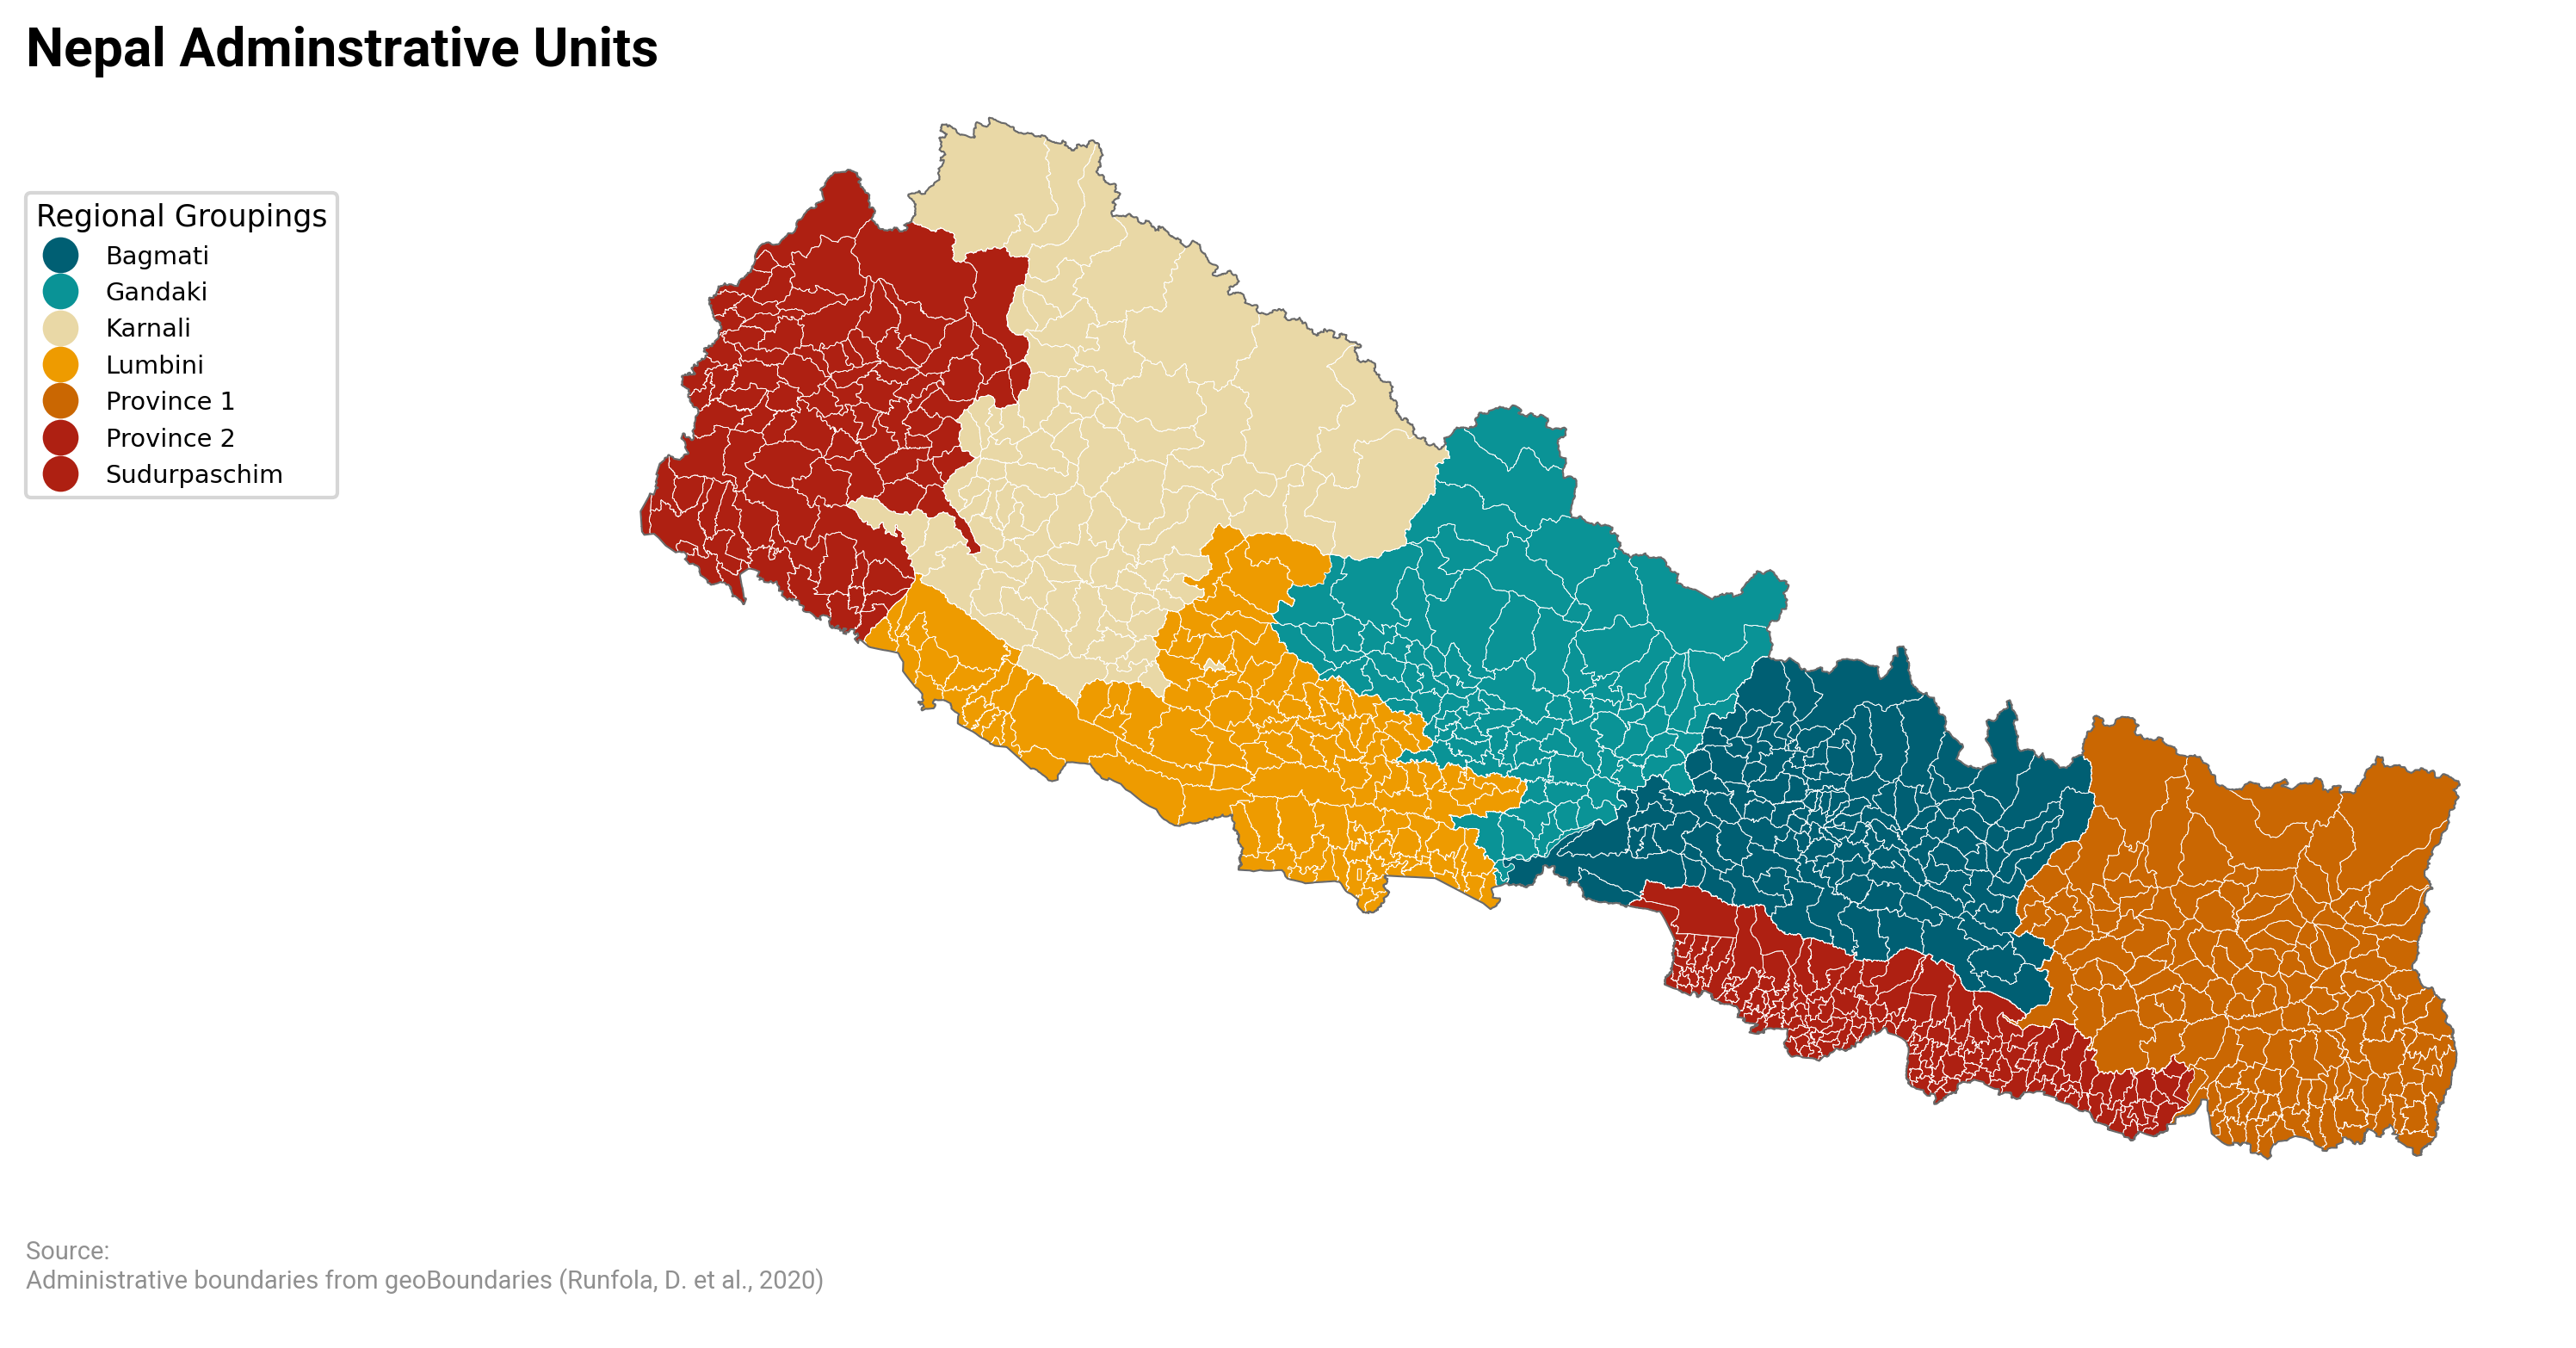

In [ ]:
geoplot.plot_geoboundaries(
    adm_level="ADM2",
    group="ADM1"
);

## Plot Asset Distribution

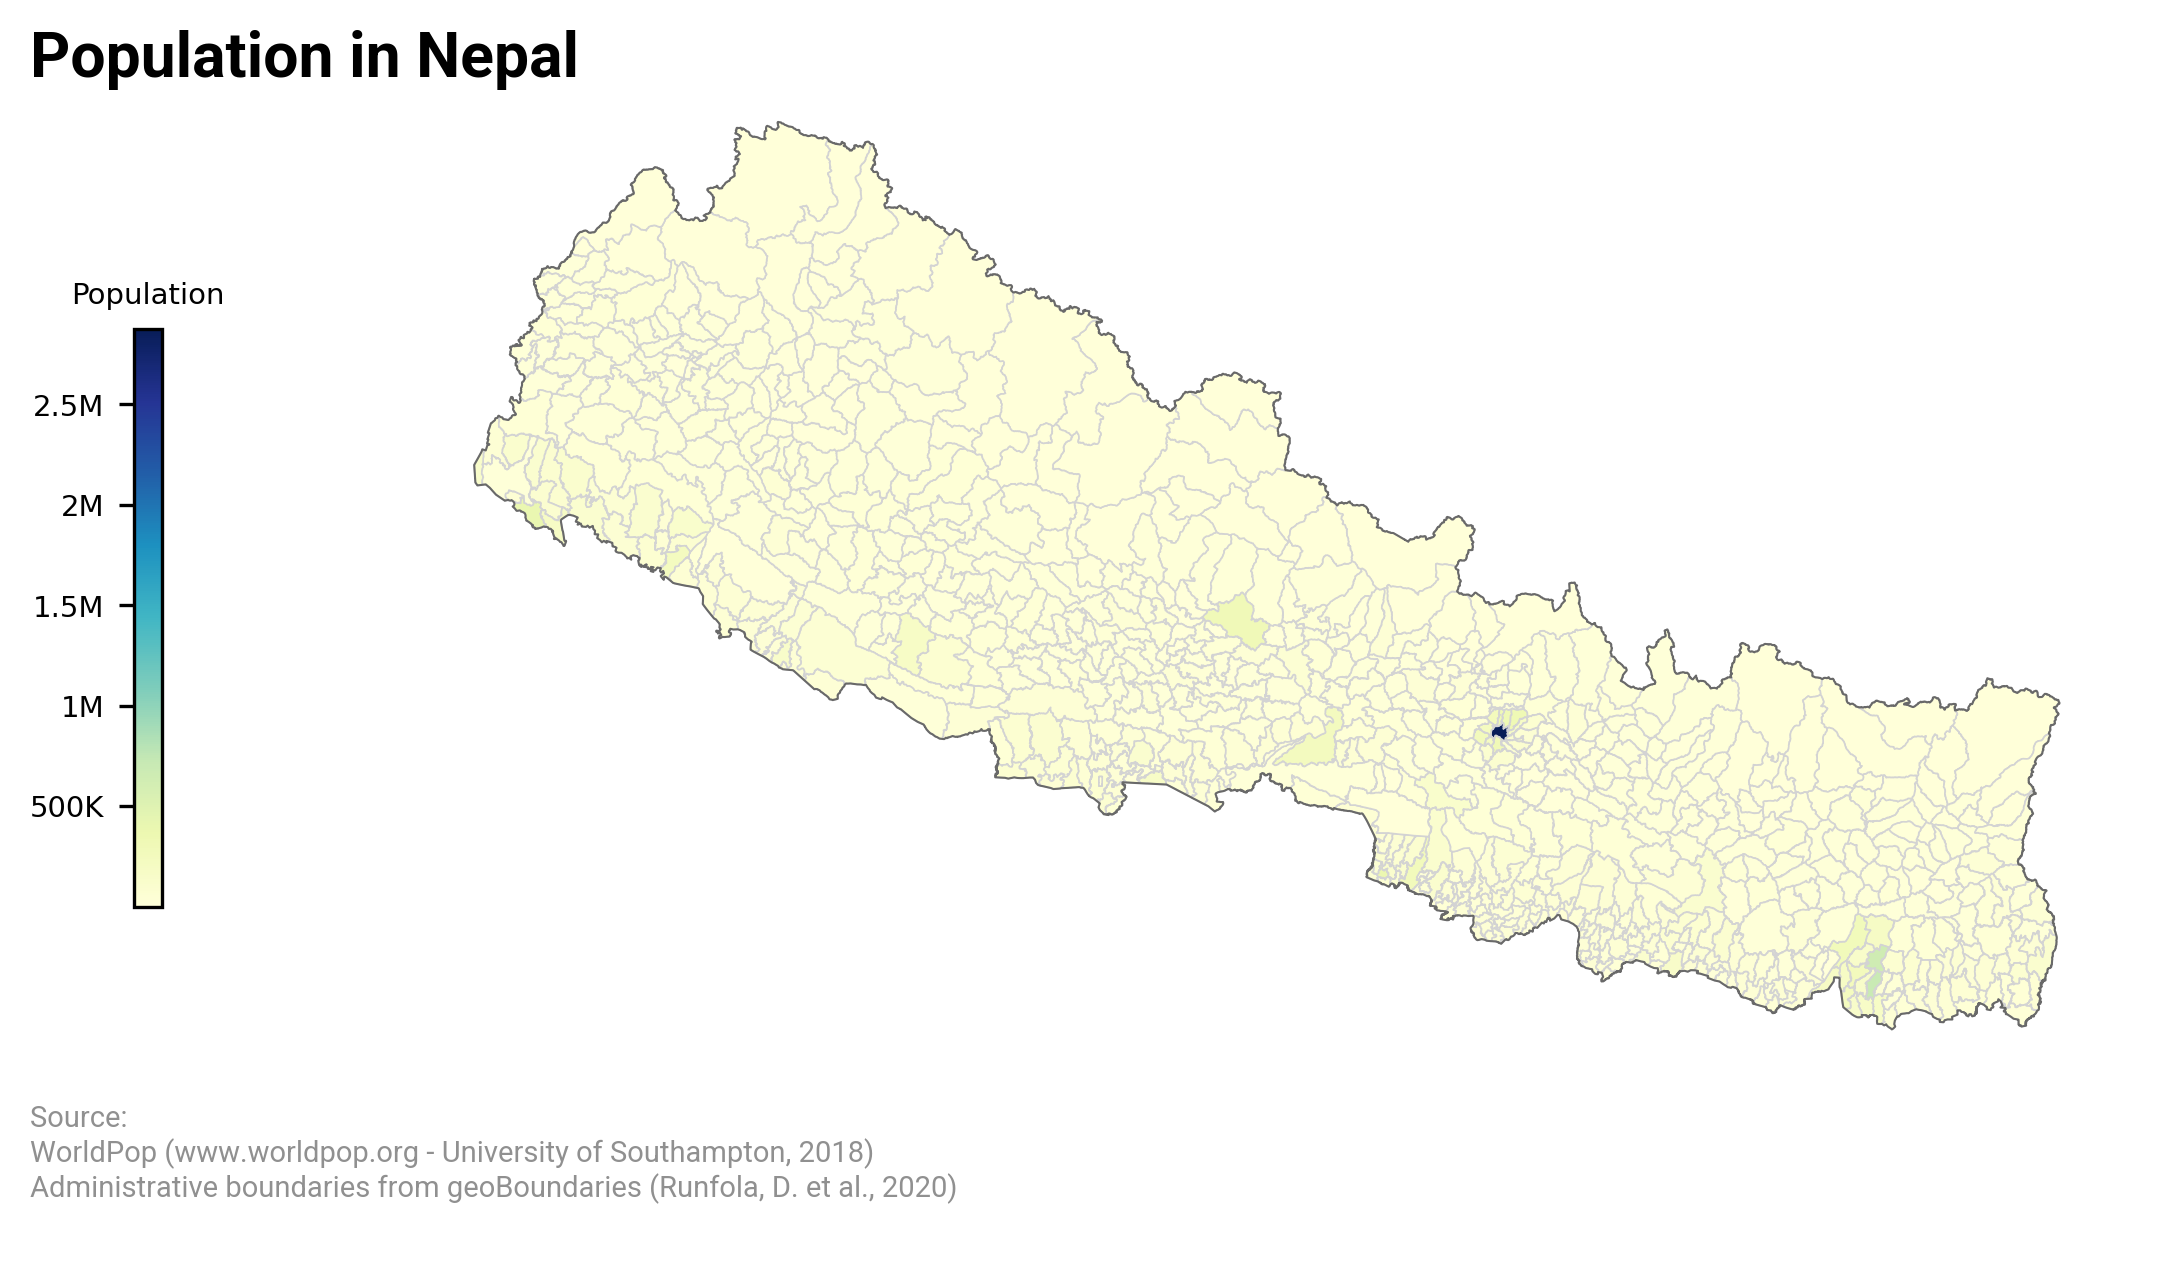

In [ ]:
# @markdown ### Plot Asset Distribution
asset_data_source = "worldpop" # @param ["worldpop", "bem"]

# @markdown ---

# @markdown ### Zoom to specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}

# @markdown ---
# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 10 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var=asset_data_source,
    kwargs={
        "legend_type": "colorbar",
    },
    zoom_to=zoom_to
)

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Plot Displacement (IOM DTM)

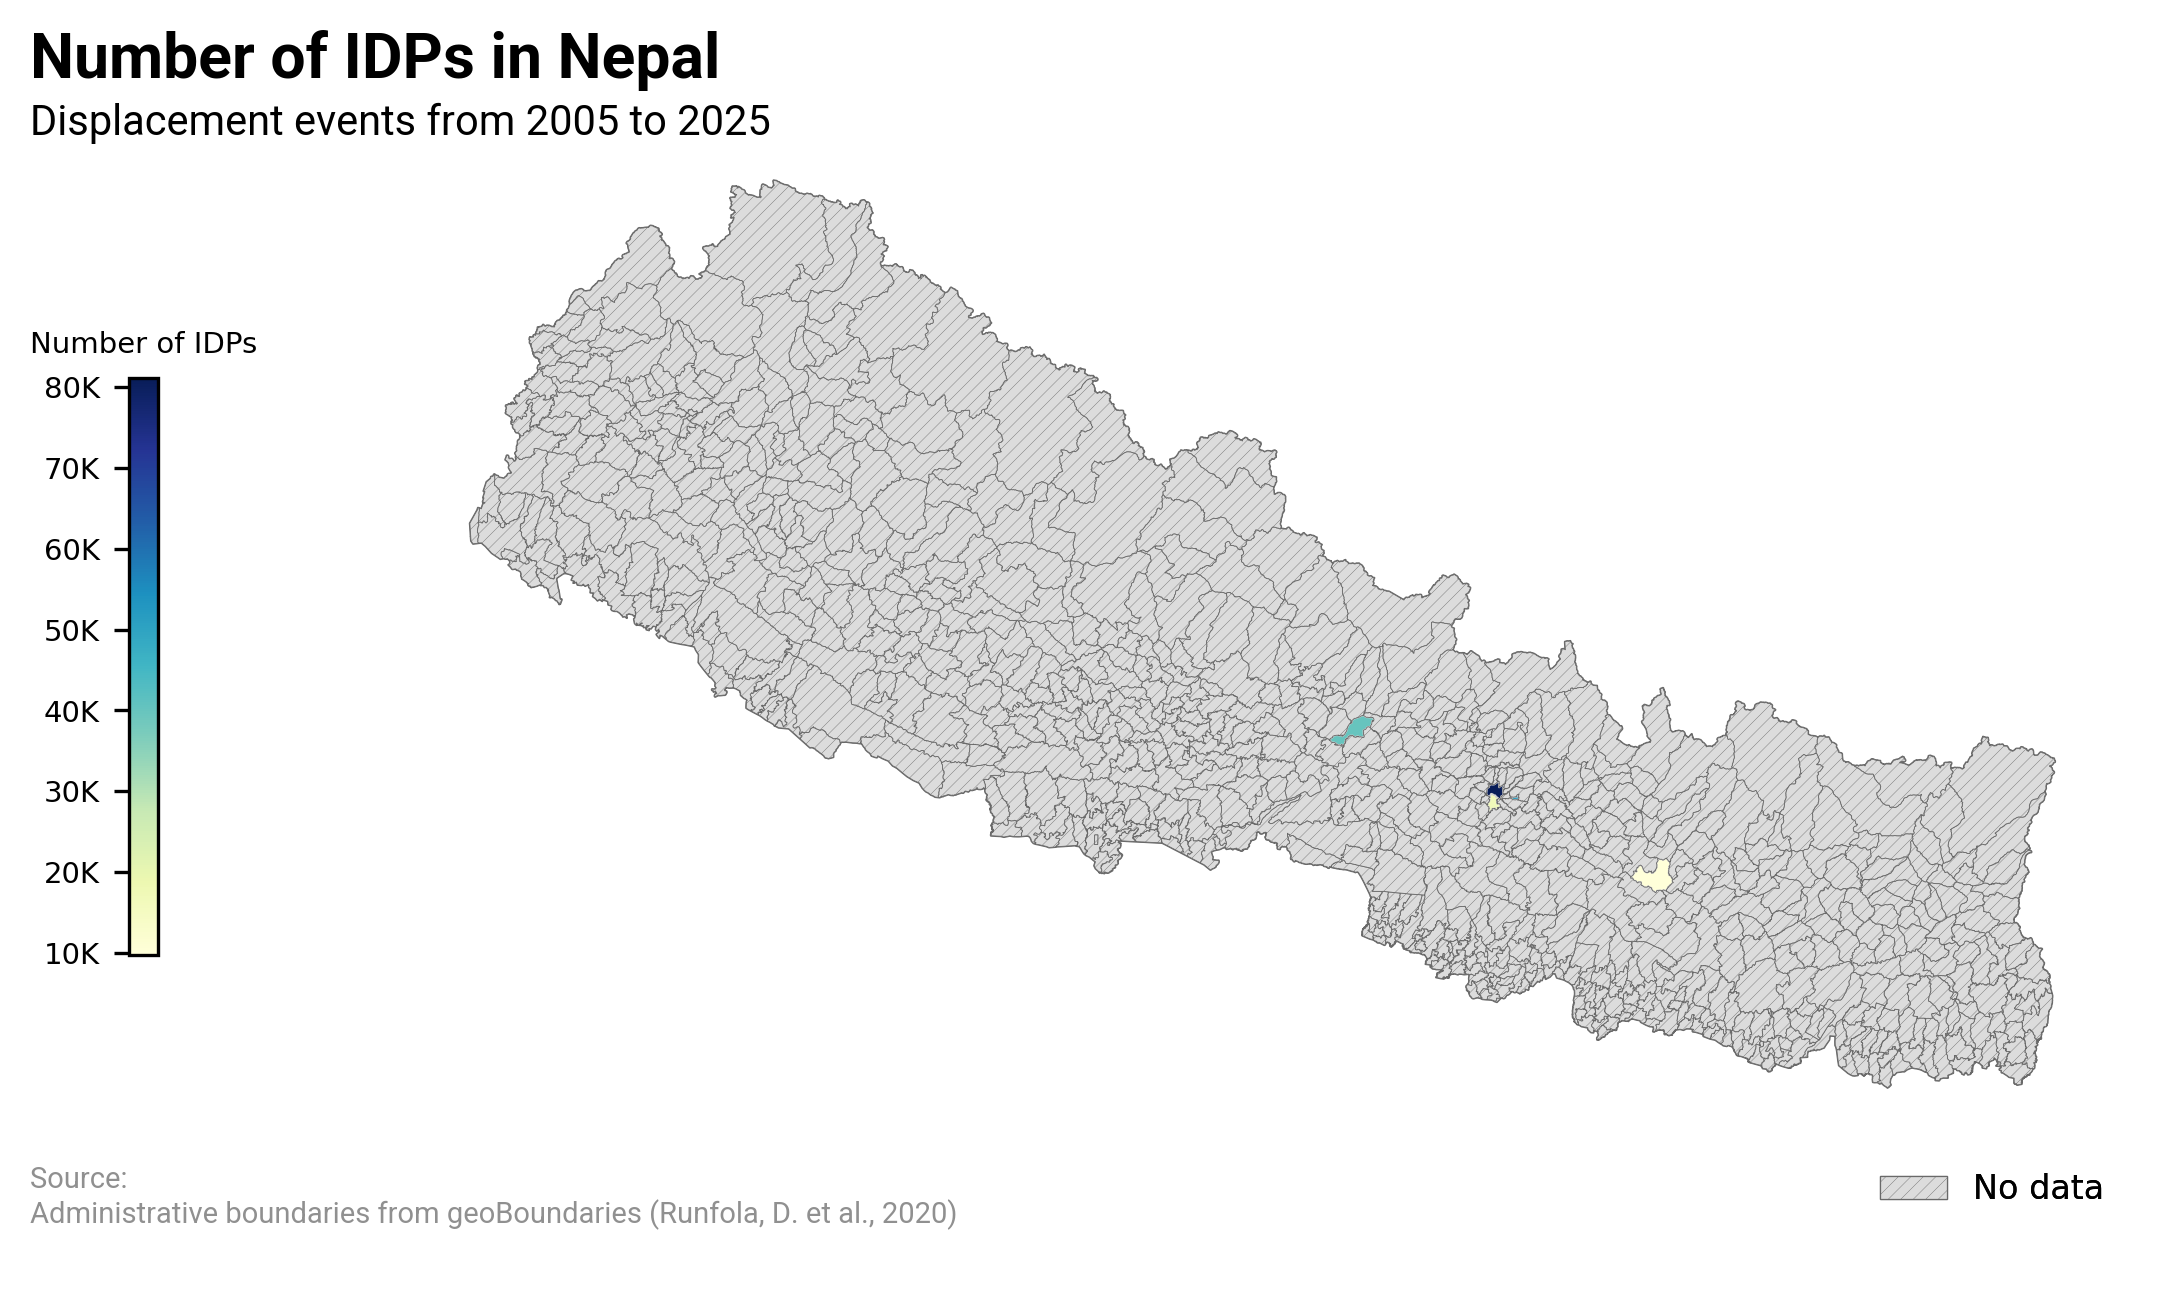

In [ ]:
# @markdown ### Plot Displacement
# @markdown ---

# @markdown ### Zoom to specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}

# @markdown ---
# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 10 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var="numPresentIdpInd",
    data=dm.dtm,
    zoom_to=zoom_to,
    kwargs={
        "legend_type": "colorbar",
    }
)

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Plot Conflict Stats

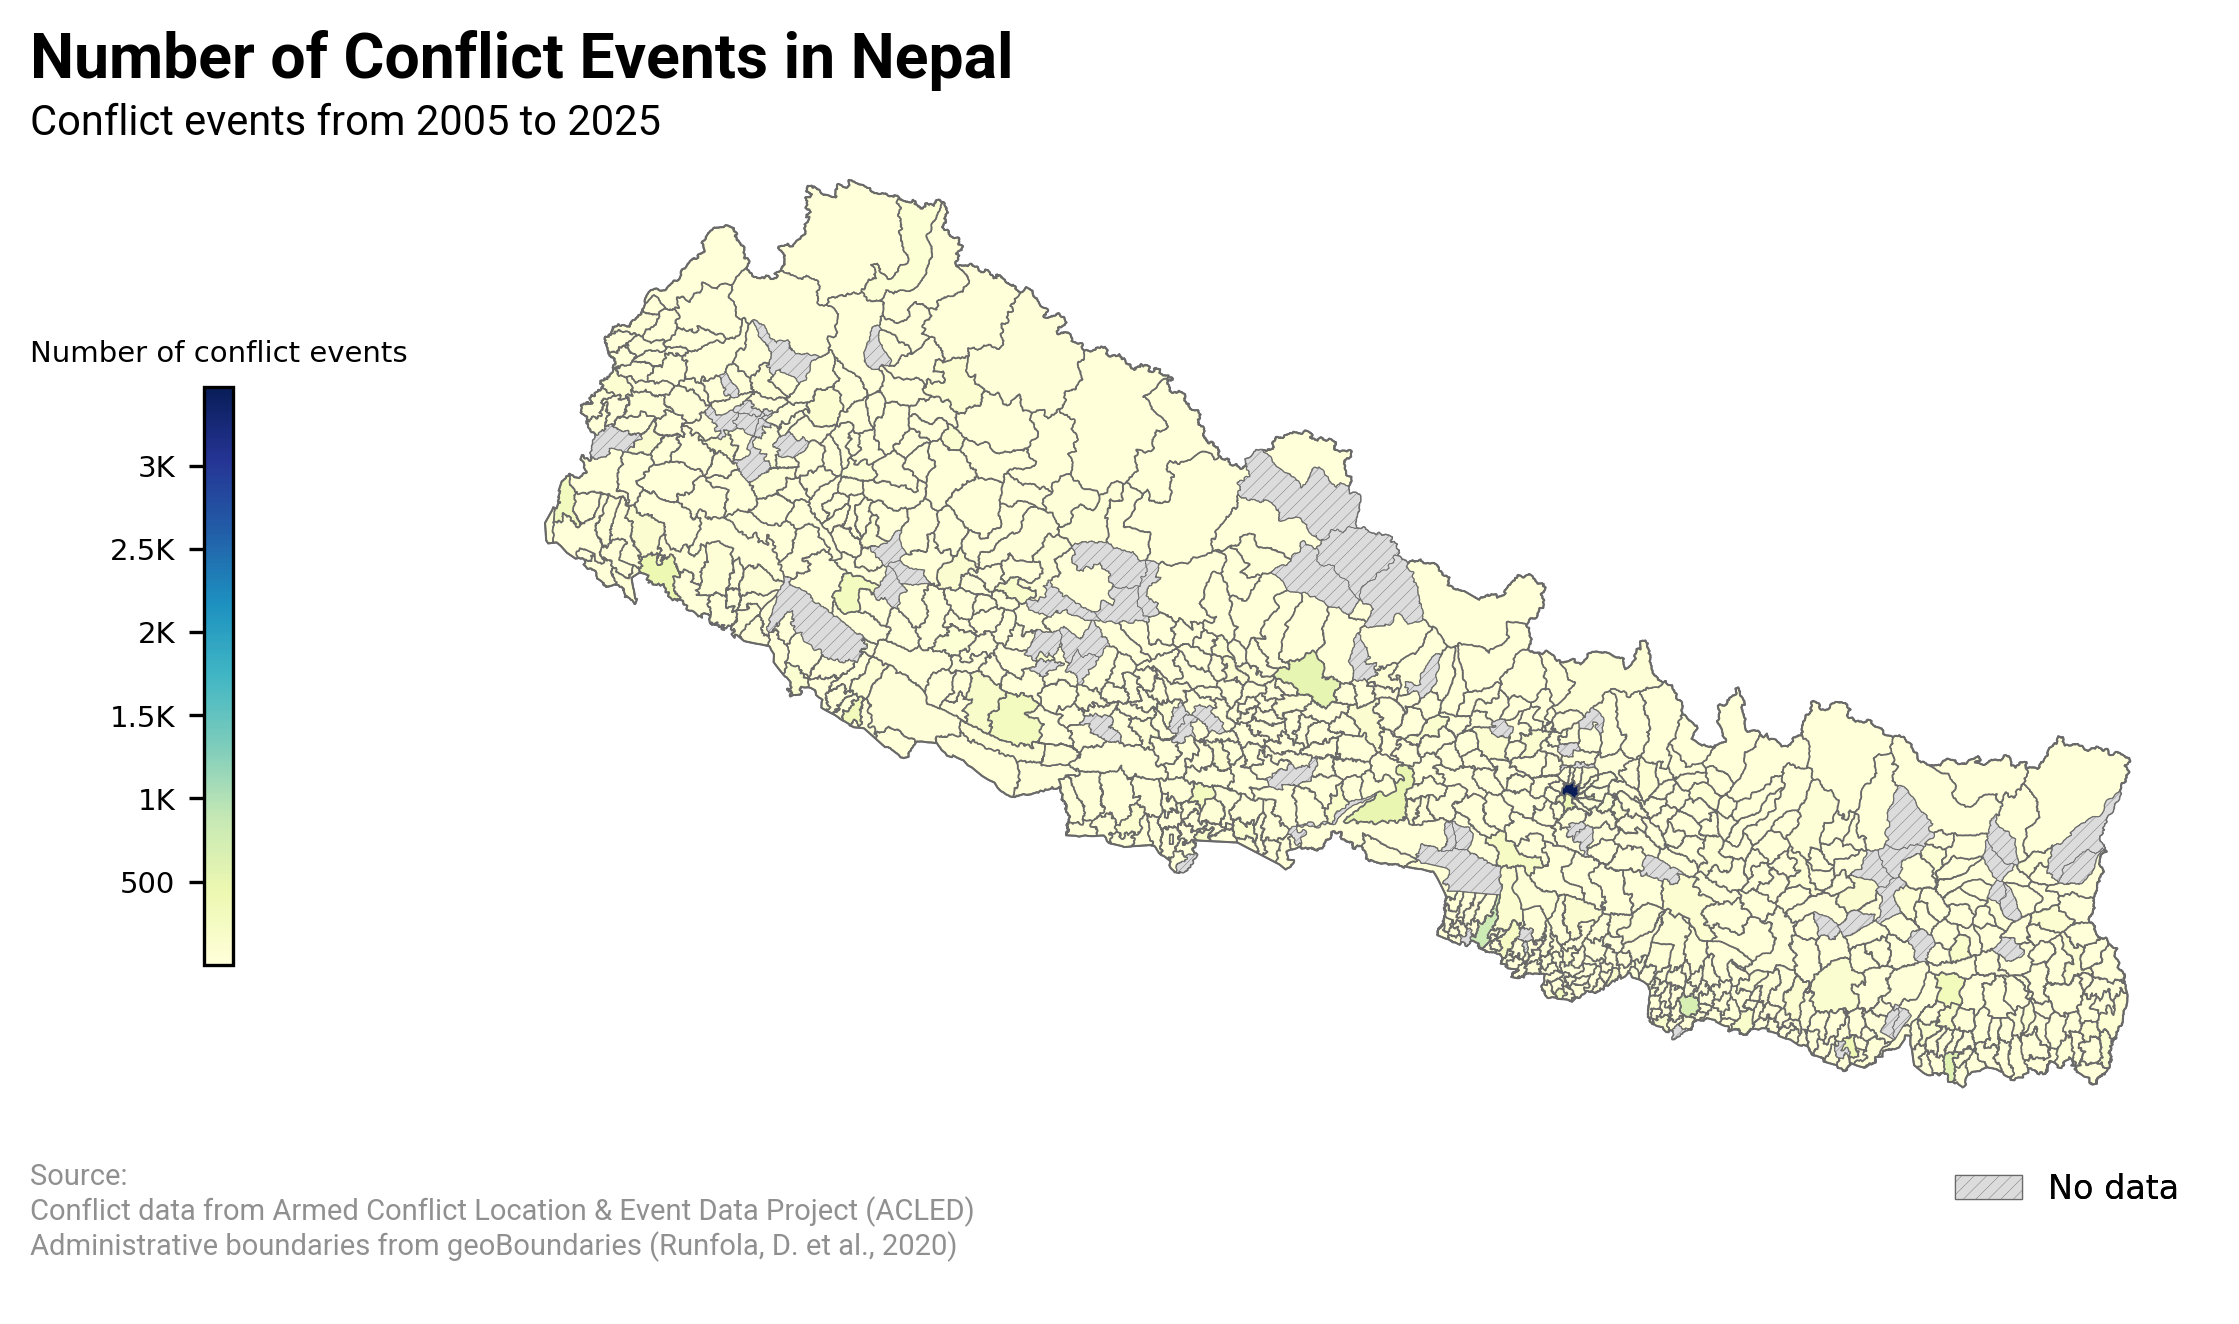

In [ ]:
# @markdown ### Plot Conflict statistics
conflict_data_source = "ACLED" # @param ["ACLED", "UCDP"]
conflict_column = "conflict_count" # @param ["conflict_count", "fatalities", "fatalities_per_conflict"]

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var=f"{conflict_data_source.lower()}_{conflict_column}",
    kwargs={
        "legend_type": "colorbar",
        "palette_name": "Reds",
        "edgecolor": "dimgray"
    },
    zoom_to=zoom_to
)

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Plot Conflict Exposure

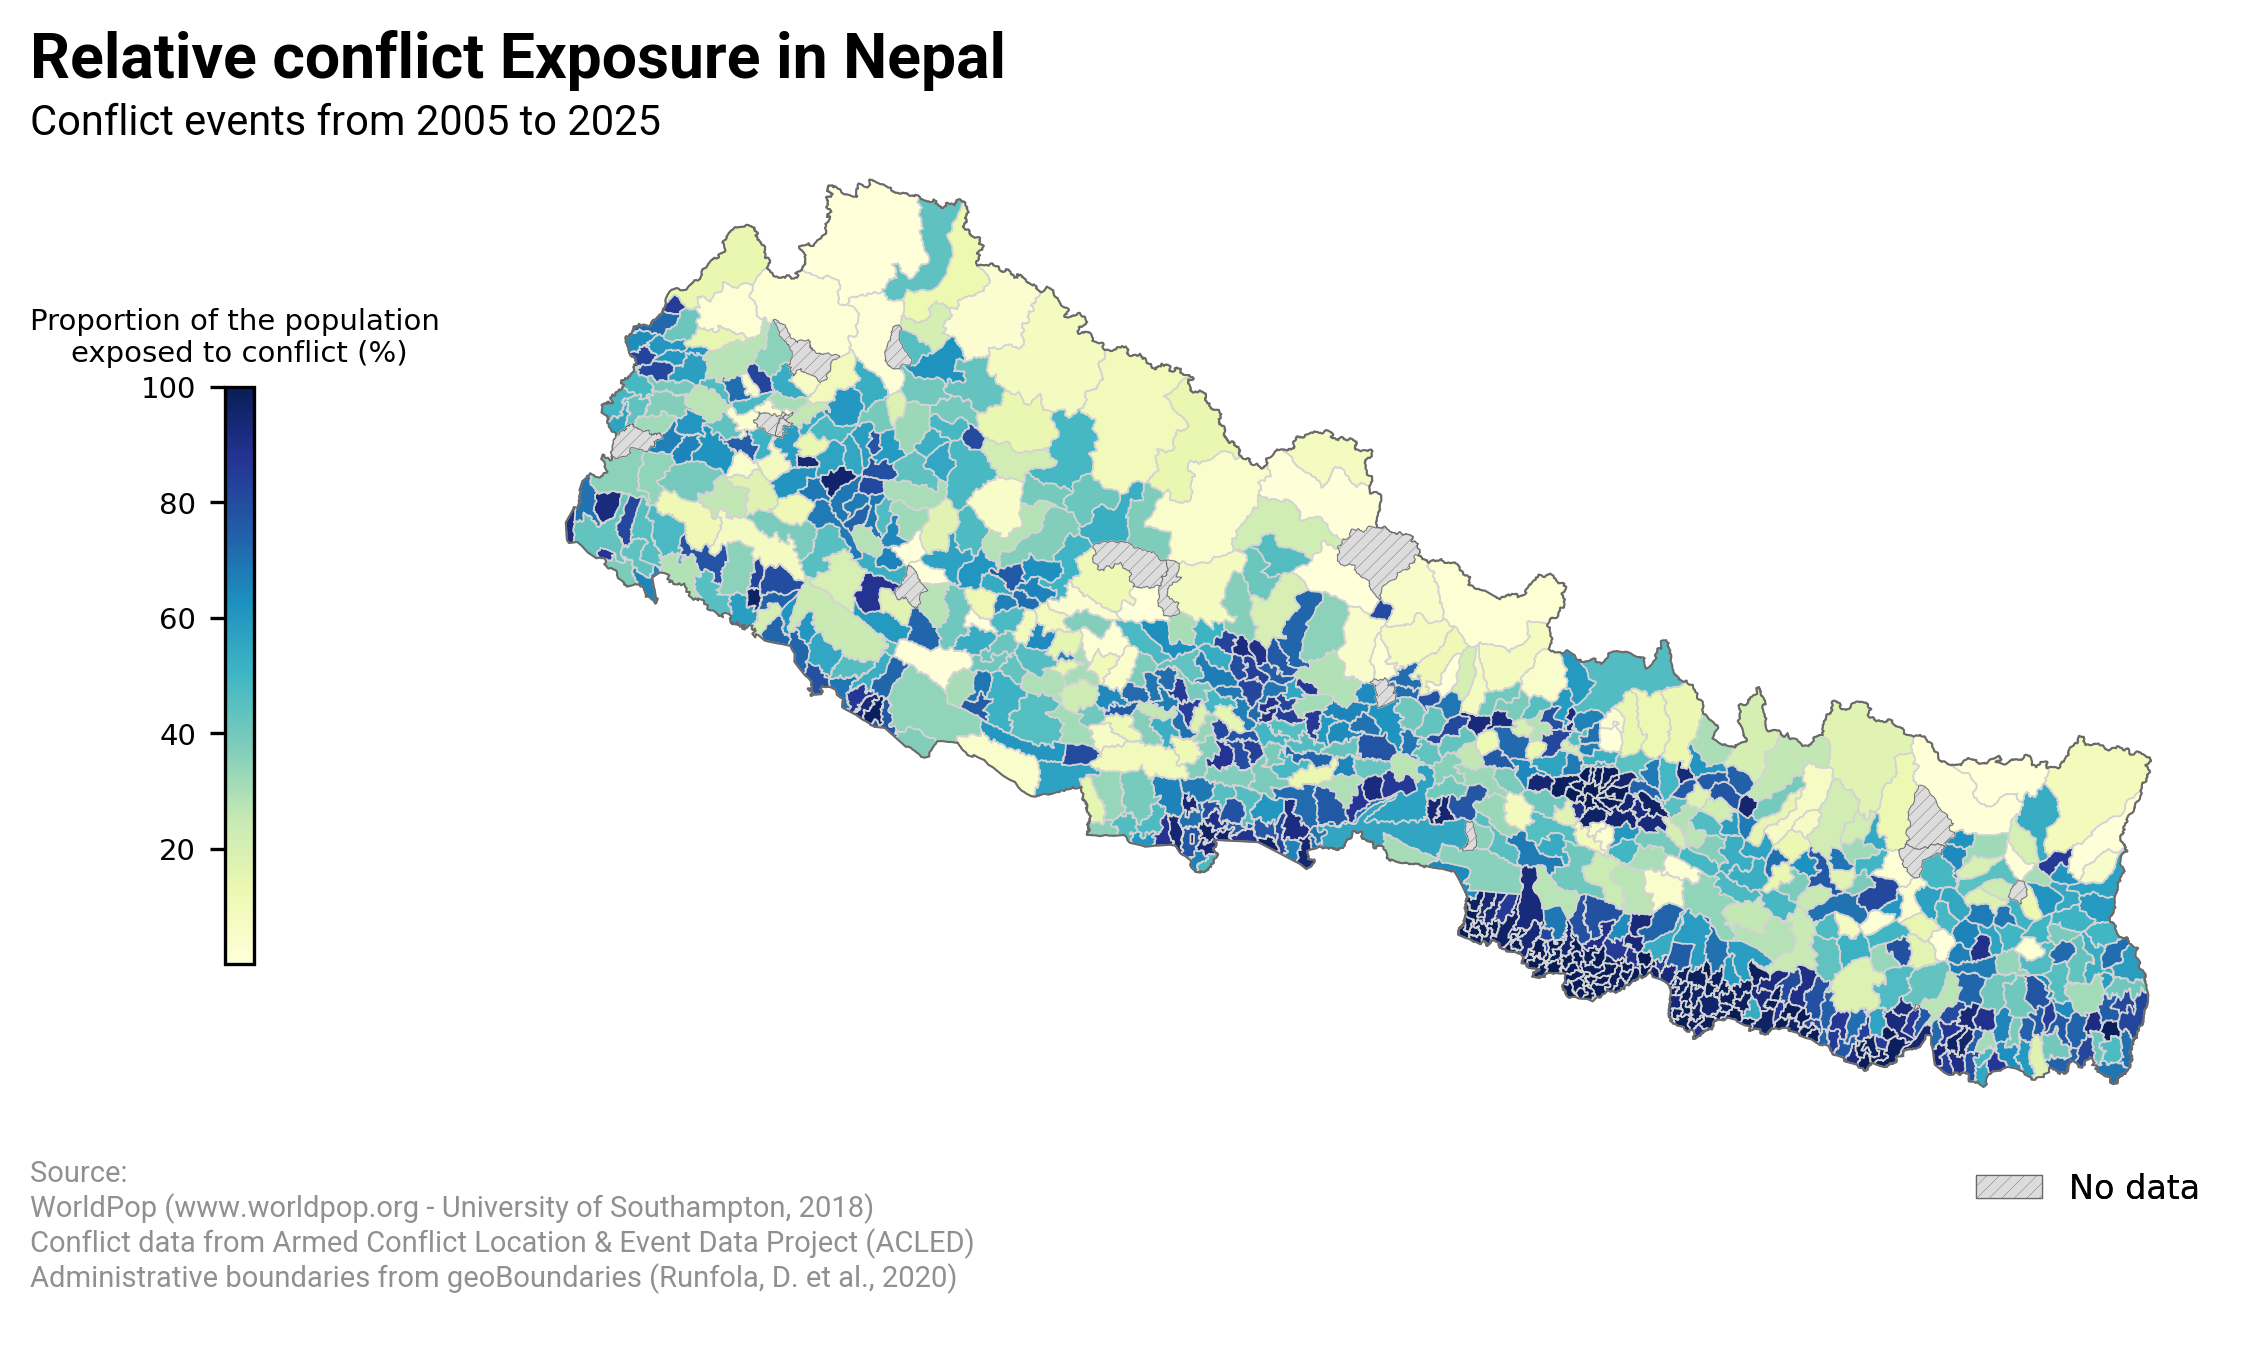

In [ ]:
# @markdown ### Plot Conflict Exposure
conflict_exposure_source = "ACLED (WBG calculation)" # @param ["ACLED (population_best)", "ACLED (WBG calculation)", "UCDP"]
exposure = "relative" # @param ["absolute", "relative"]

source = data_utils.get_conflict_source(dm, conflict_exposure_source)
exposure = data_utils.get_exposure(dm, exposure)

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var=f"{source}_{exposure}",
    kwargs={"legend_type": "colorbar"},
    zoom_to=zoom_to
);

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Map Exposure to a Single Hazard

/usr/local/lib/python3.12/dist-packages/dfcv_colocation_mapping/map_utils.py:325: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=config["cbar_fontsize"])


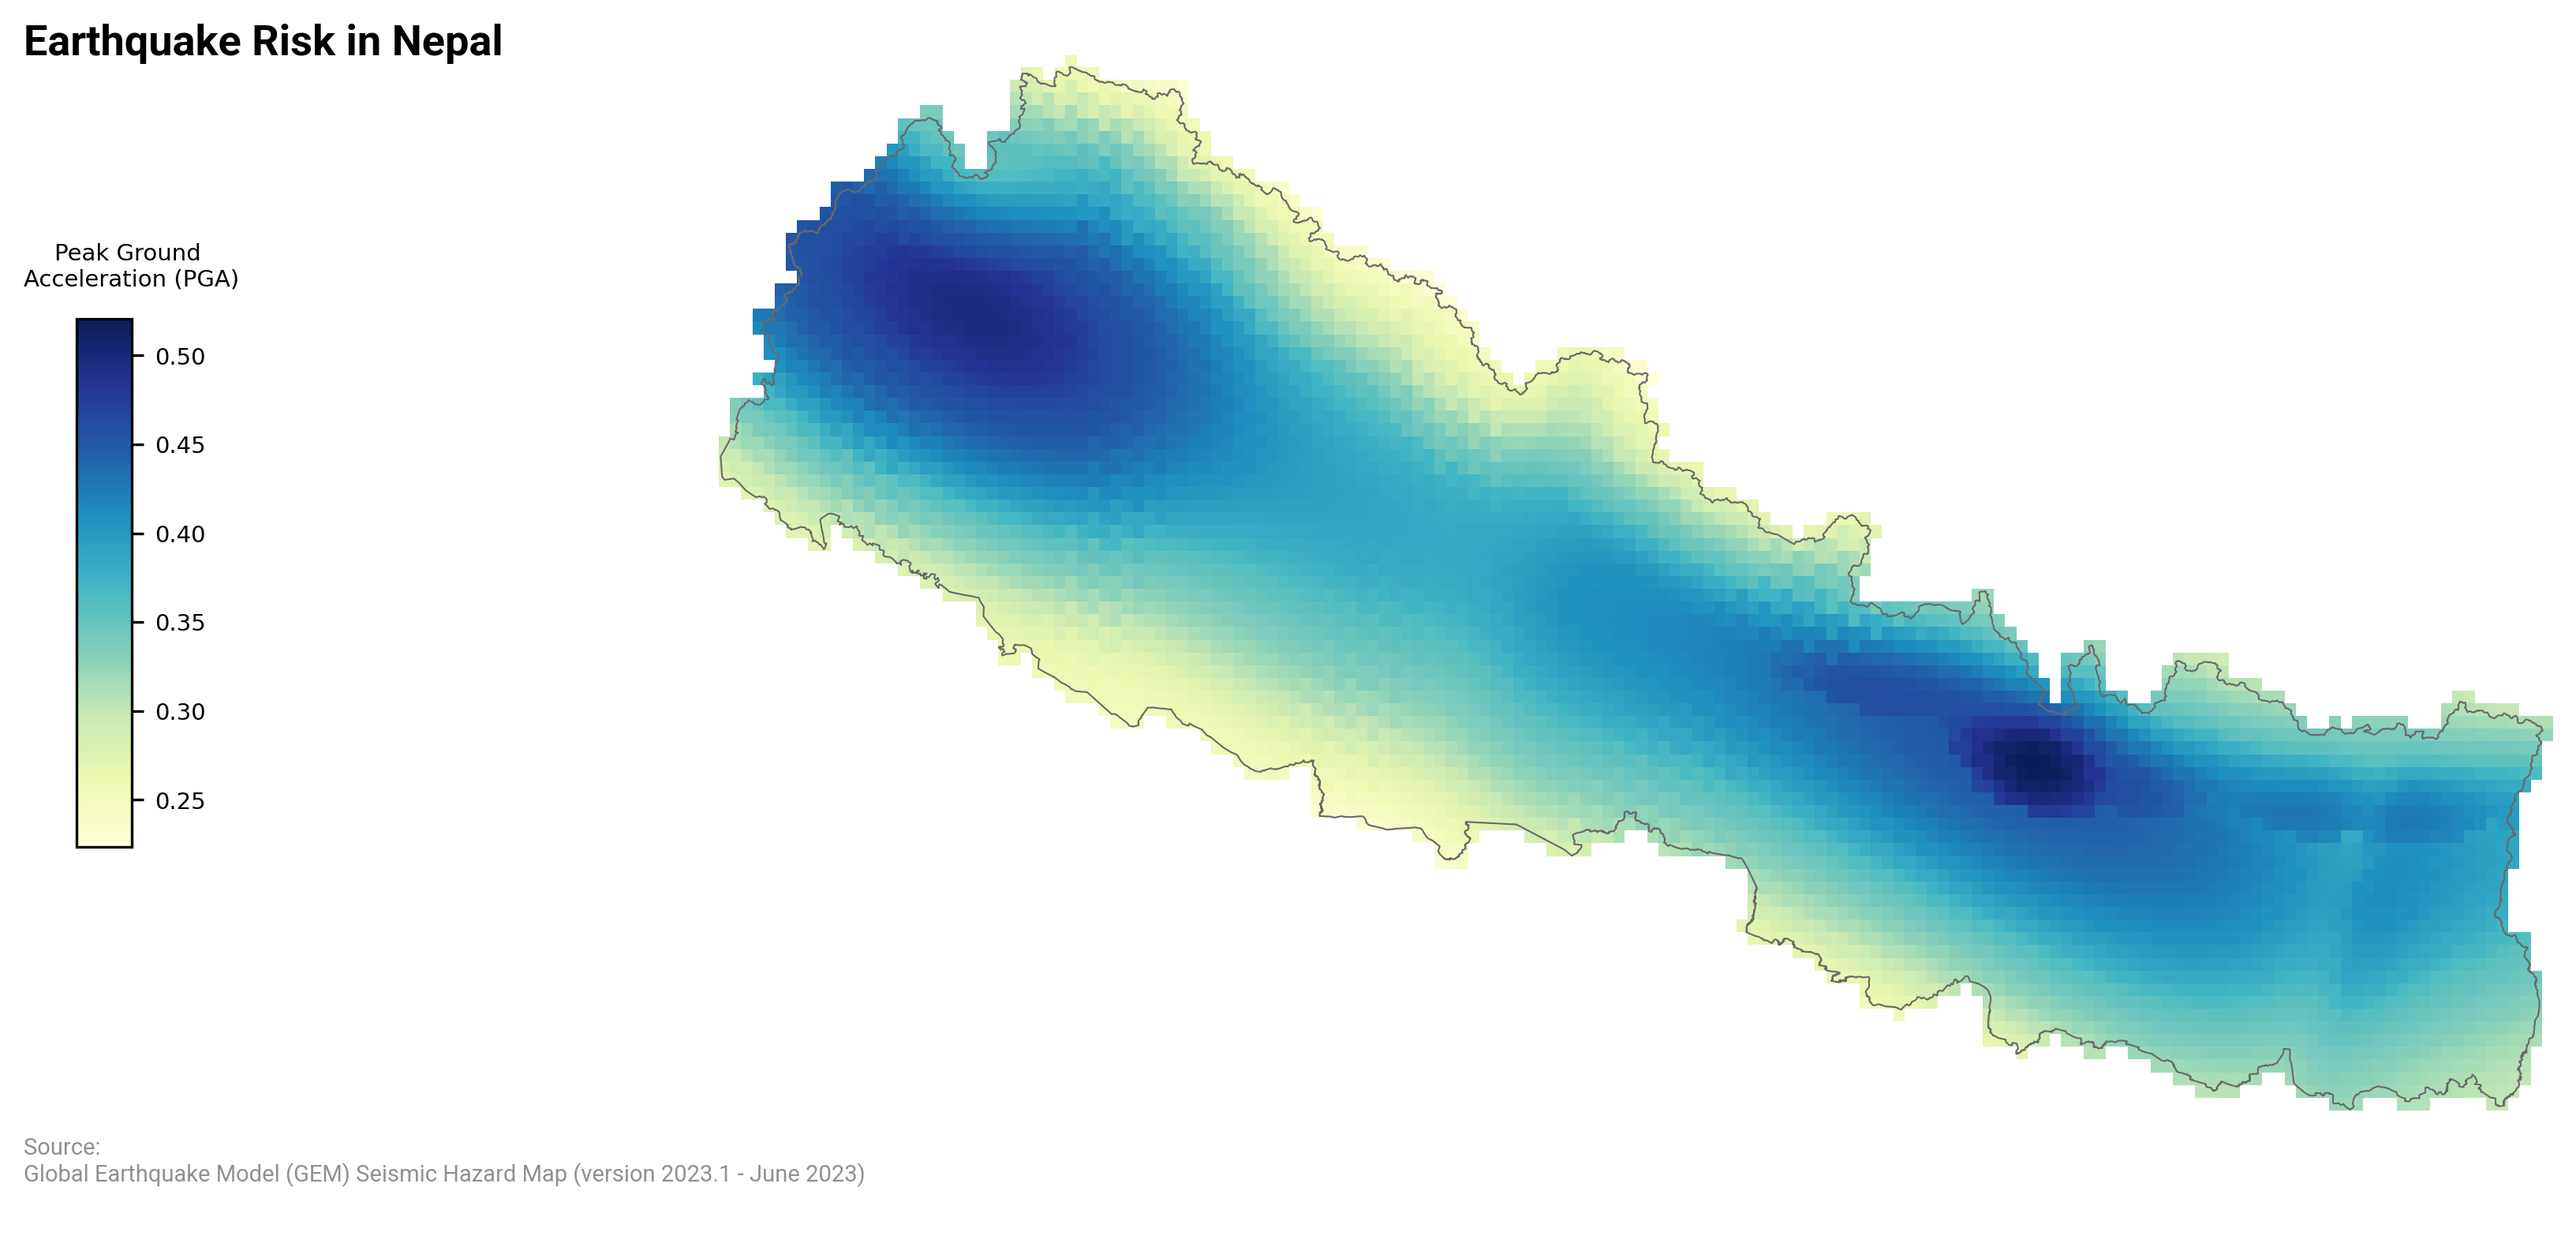

In [ ]:
hazard = "earthquake" # @param ["earthquake", "landslide", "cyclone", "drought", "heat_stress", "fluvial_flood", "wildfire"]
ax = geoplot.plot_raster(hazard);

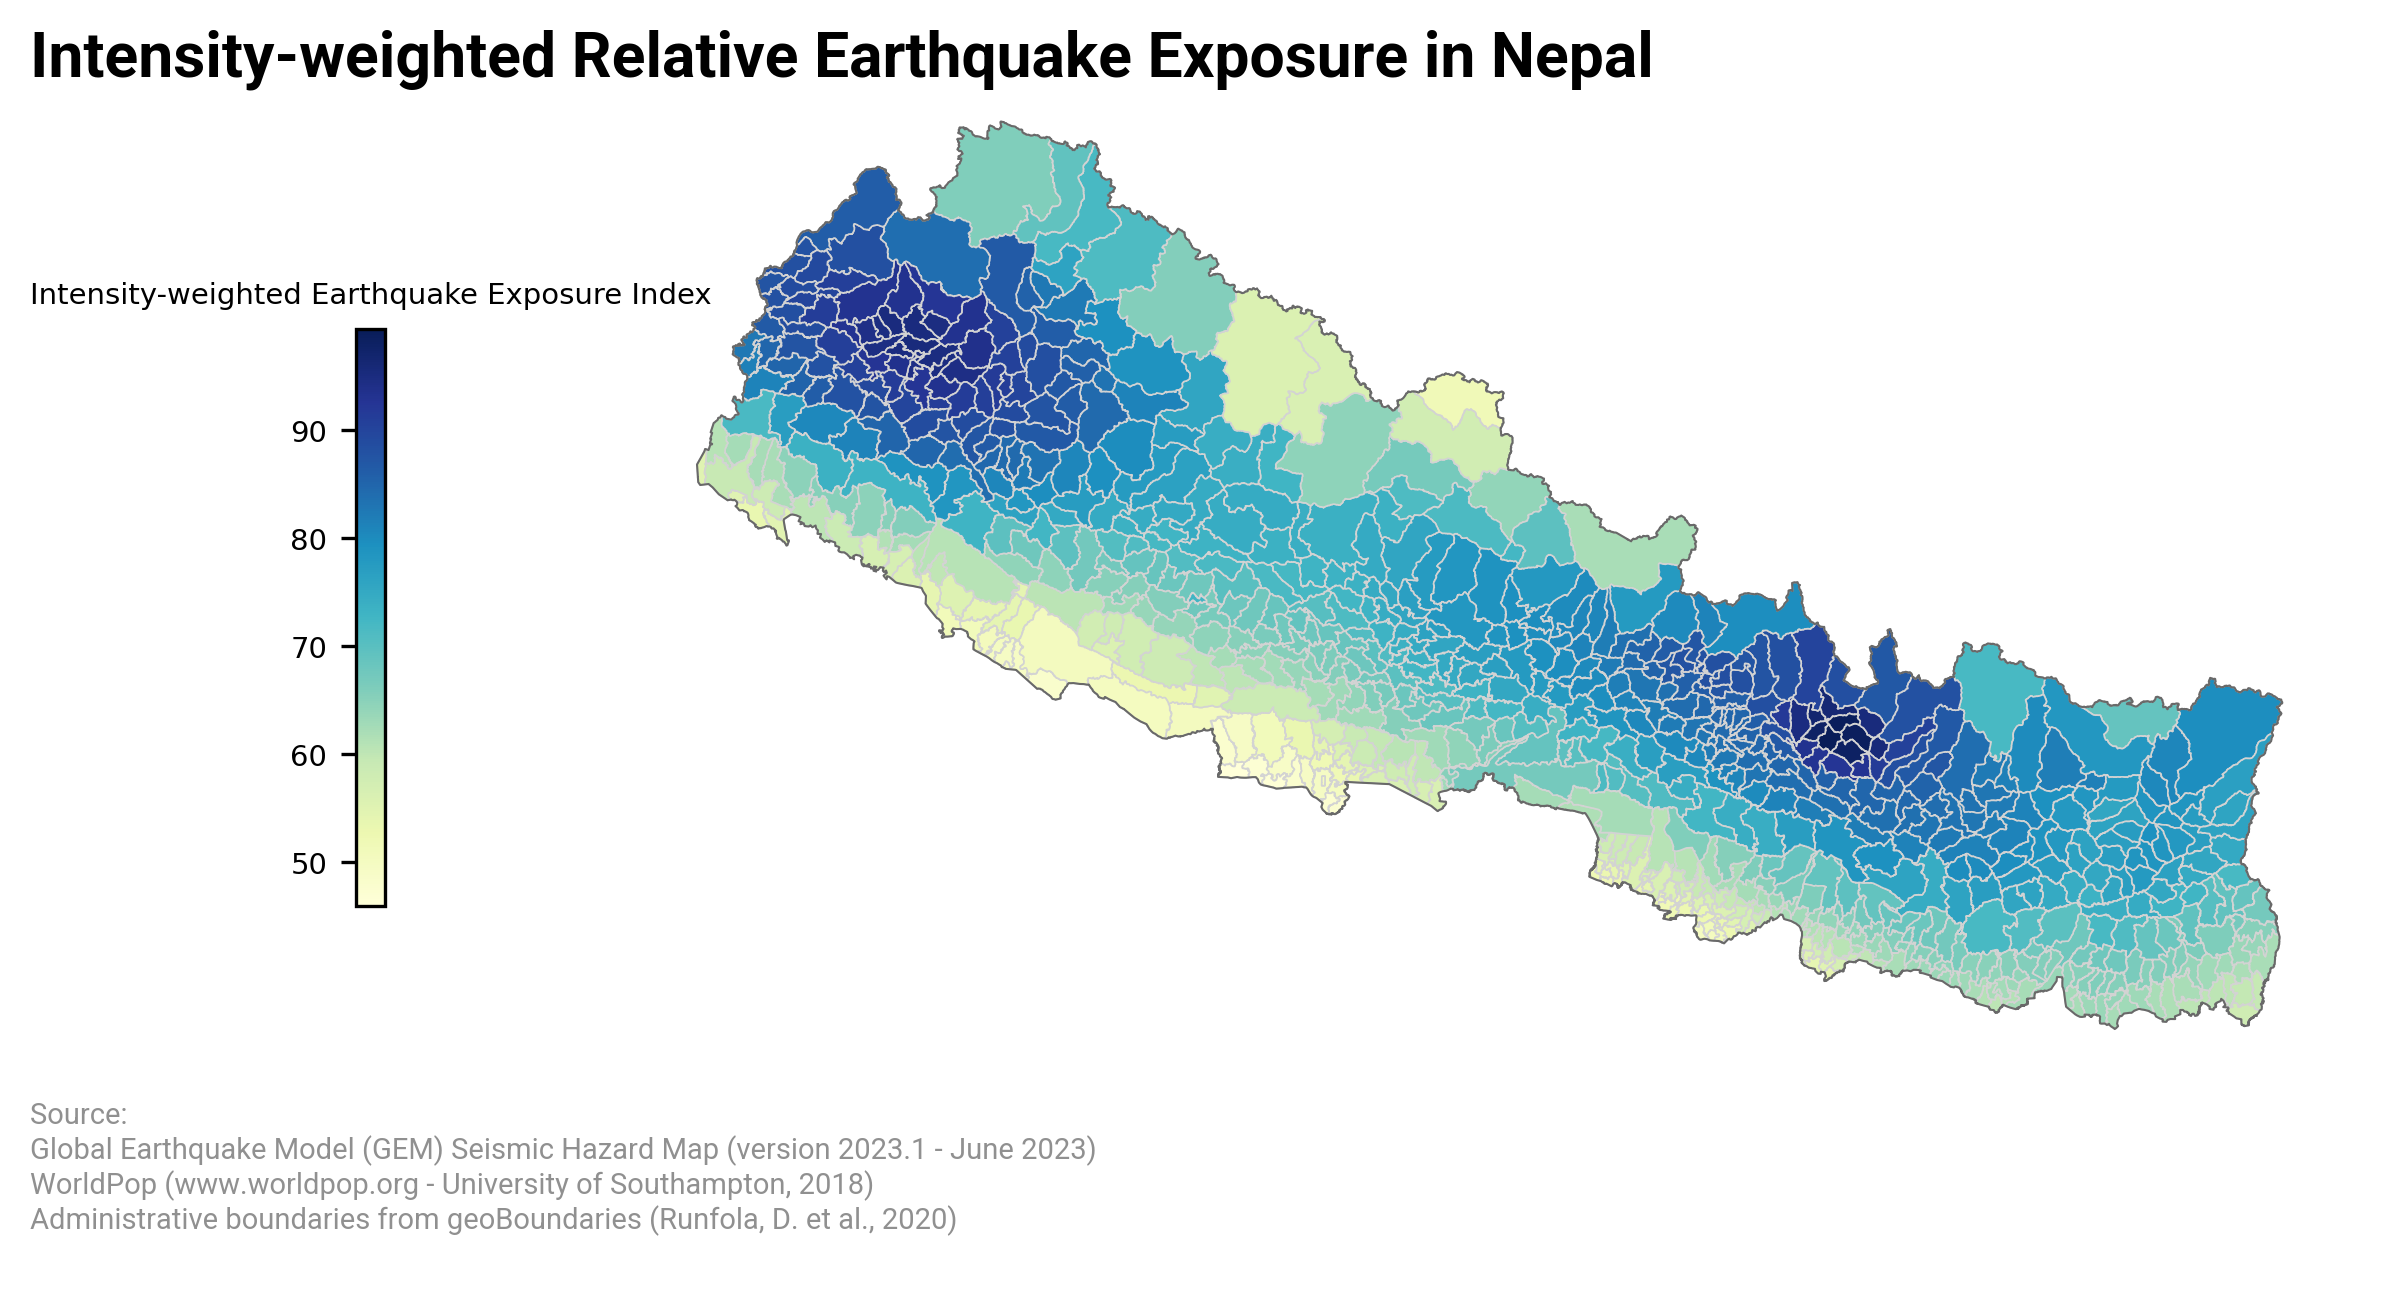

In [ ]:
# @markdown ### Plot Hazard Exposure
hazard = "earthquake" # @param ["earthquake", "landslide", "cyclone", "drought", "heat_stress", "fluvial_flood", "wildfire"]
exposure = "intensity_weighted_relative" # @param ["absolute", "relative", "intensity_weighted_relative"]
exposure = data_utils.get_exposure(dm, exposure)

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    f"{hazard}_{dm.asset}_{exposure}",
    kwargs={"legend_type": "colorbar"},
    zoom_to=zoom_to
);

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Multi-hazard Exposure Index

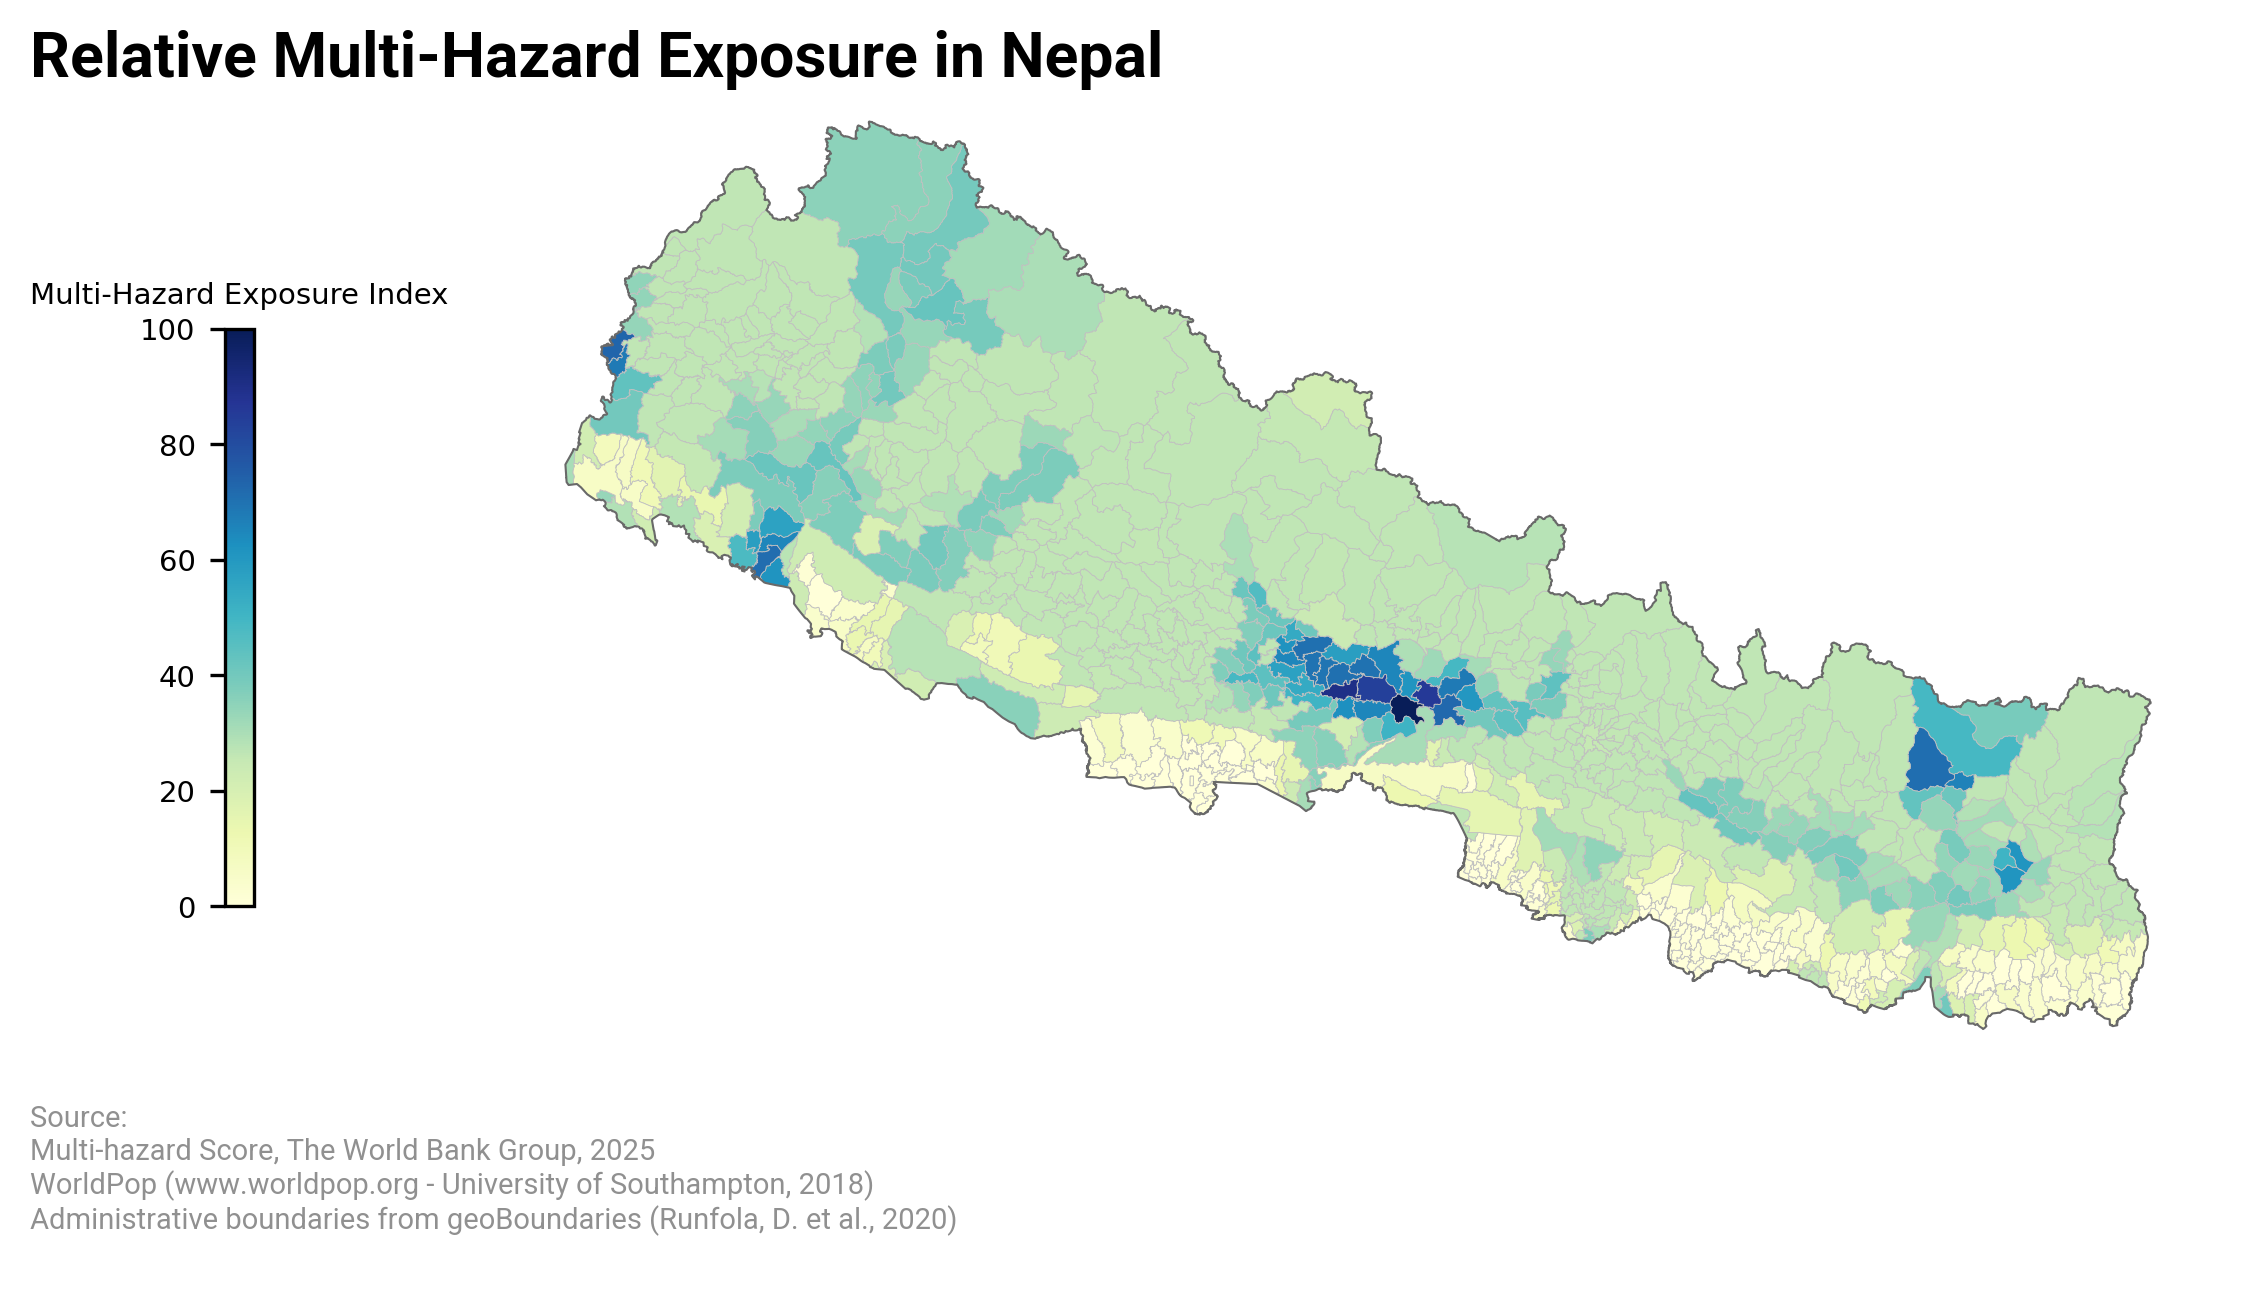

In [ ]:
# @markdown ### Plot Multi-hazard Exposure
exposure = "relative" # @param ["relative", "intensity_weighted_relative"]
exposure = data_utils.get_exposure(dm, exposure)

hazard_category = "all" # @param ["all", "hydrological", "atmospheric", "geophysical", "biophysical"]

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var=f"mhs_{hazard_category}_{dm.asset}_{exposure}",
    kwargs={
        "legend_type": "colorbar",
        "edgecolor": "silver",
        "linewidth": 0.2
    },
    zoom_to=zoom_to
);

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Generating Multi-hazard Conflict Exposure Choropleth Maps

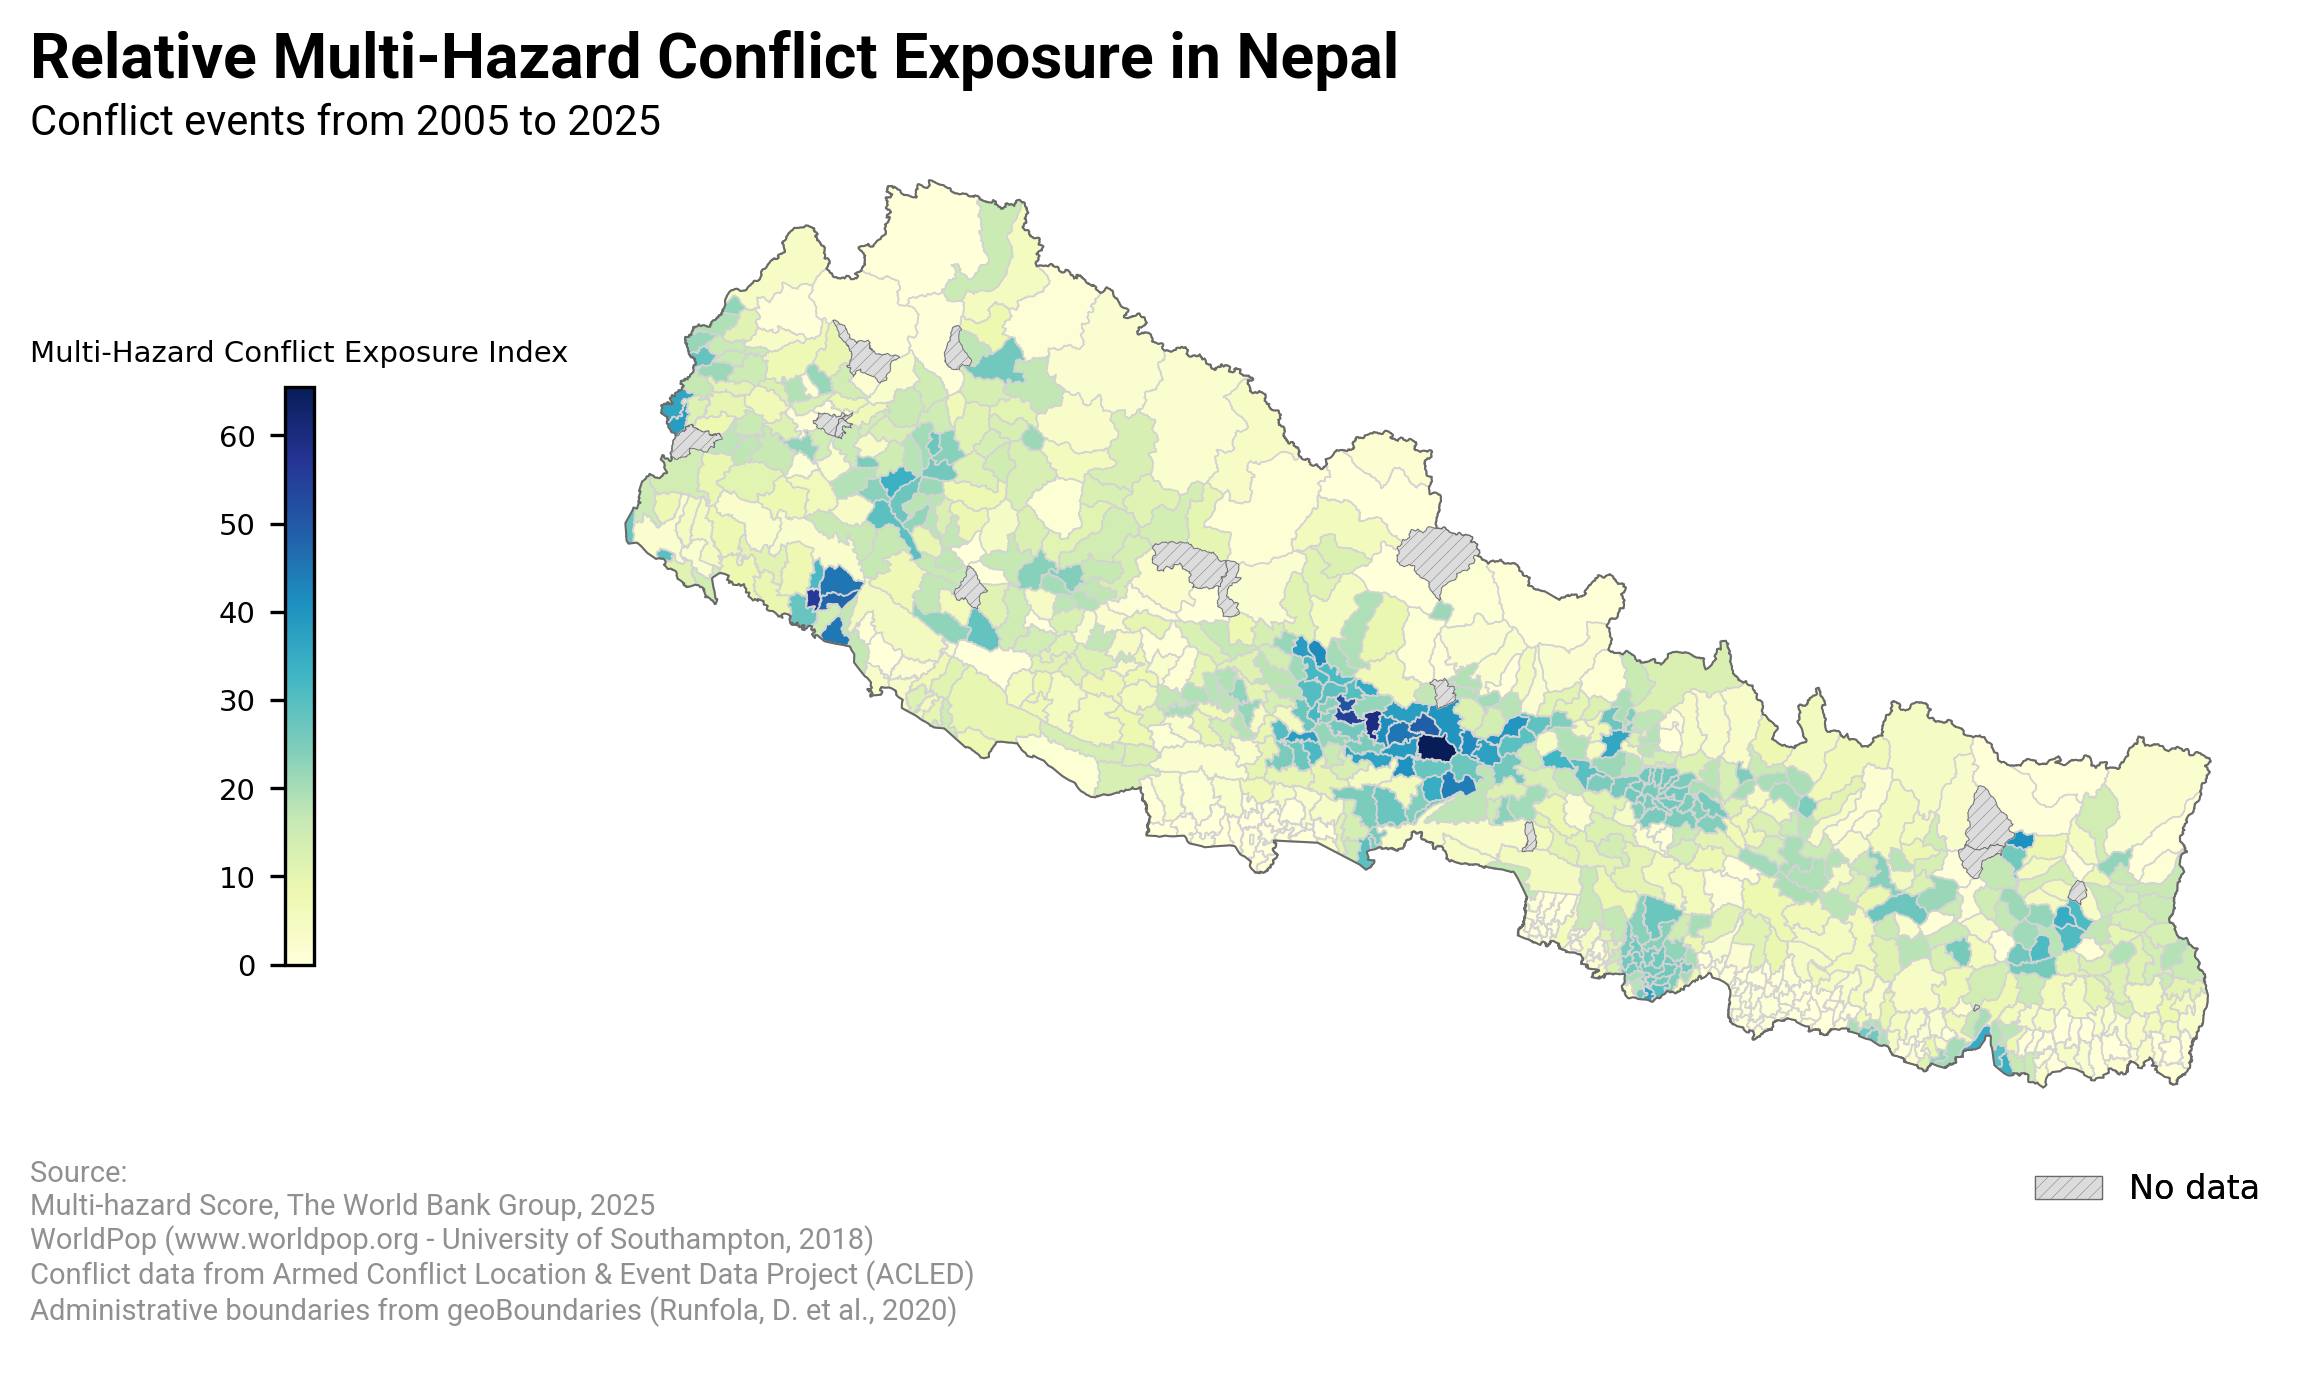

In [ ]:
# @markdown ### Plot Multi-hazard Conflict Exposure Index
conflict_exposure_source = "ACLED (WBG calculation)" # @param ["ACLED (WBG calculation)", "UCDP"]
source = data_utils.get_conflict_source(dm, conflict_exposure_source)

hazard_category = "all" # @param ["all", "hydrological", "atmospheric", "geophysical", "biophysical"]

mhs_exposure = "relative" # @param ["relative", "intensity_weighted_relative"]
exposure = data_utils.get_exposure(dm, mhs_exposure)

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_choropleth(
    var=f"mhs_{hazard_category}_{source}_{exposure}",
    kwargs={"legend_type": "colorbar"},
    zoom_to=zoom_to
);

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Generating Multi-hazard Conflict Exposure Bi-variate Choropleth Maps

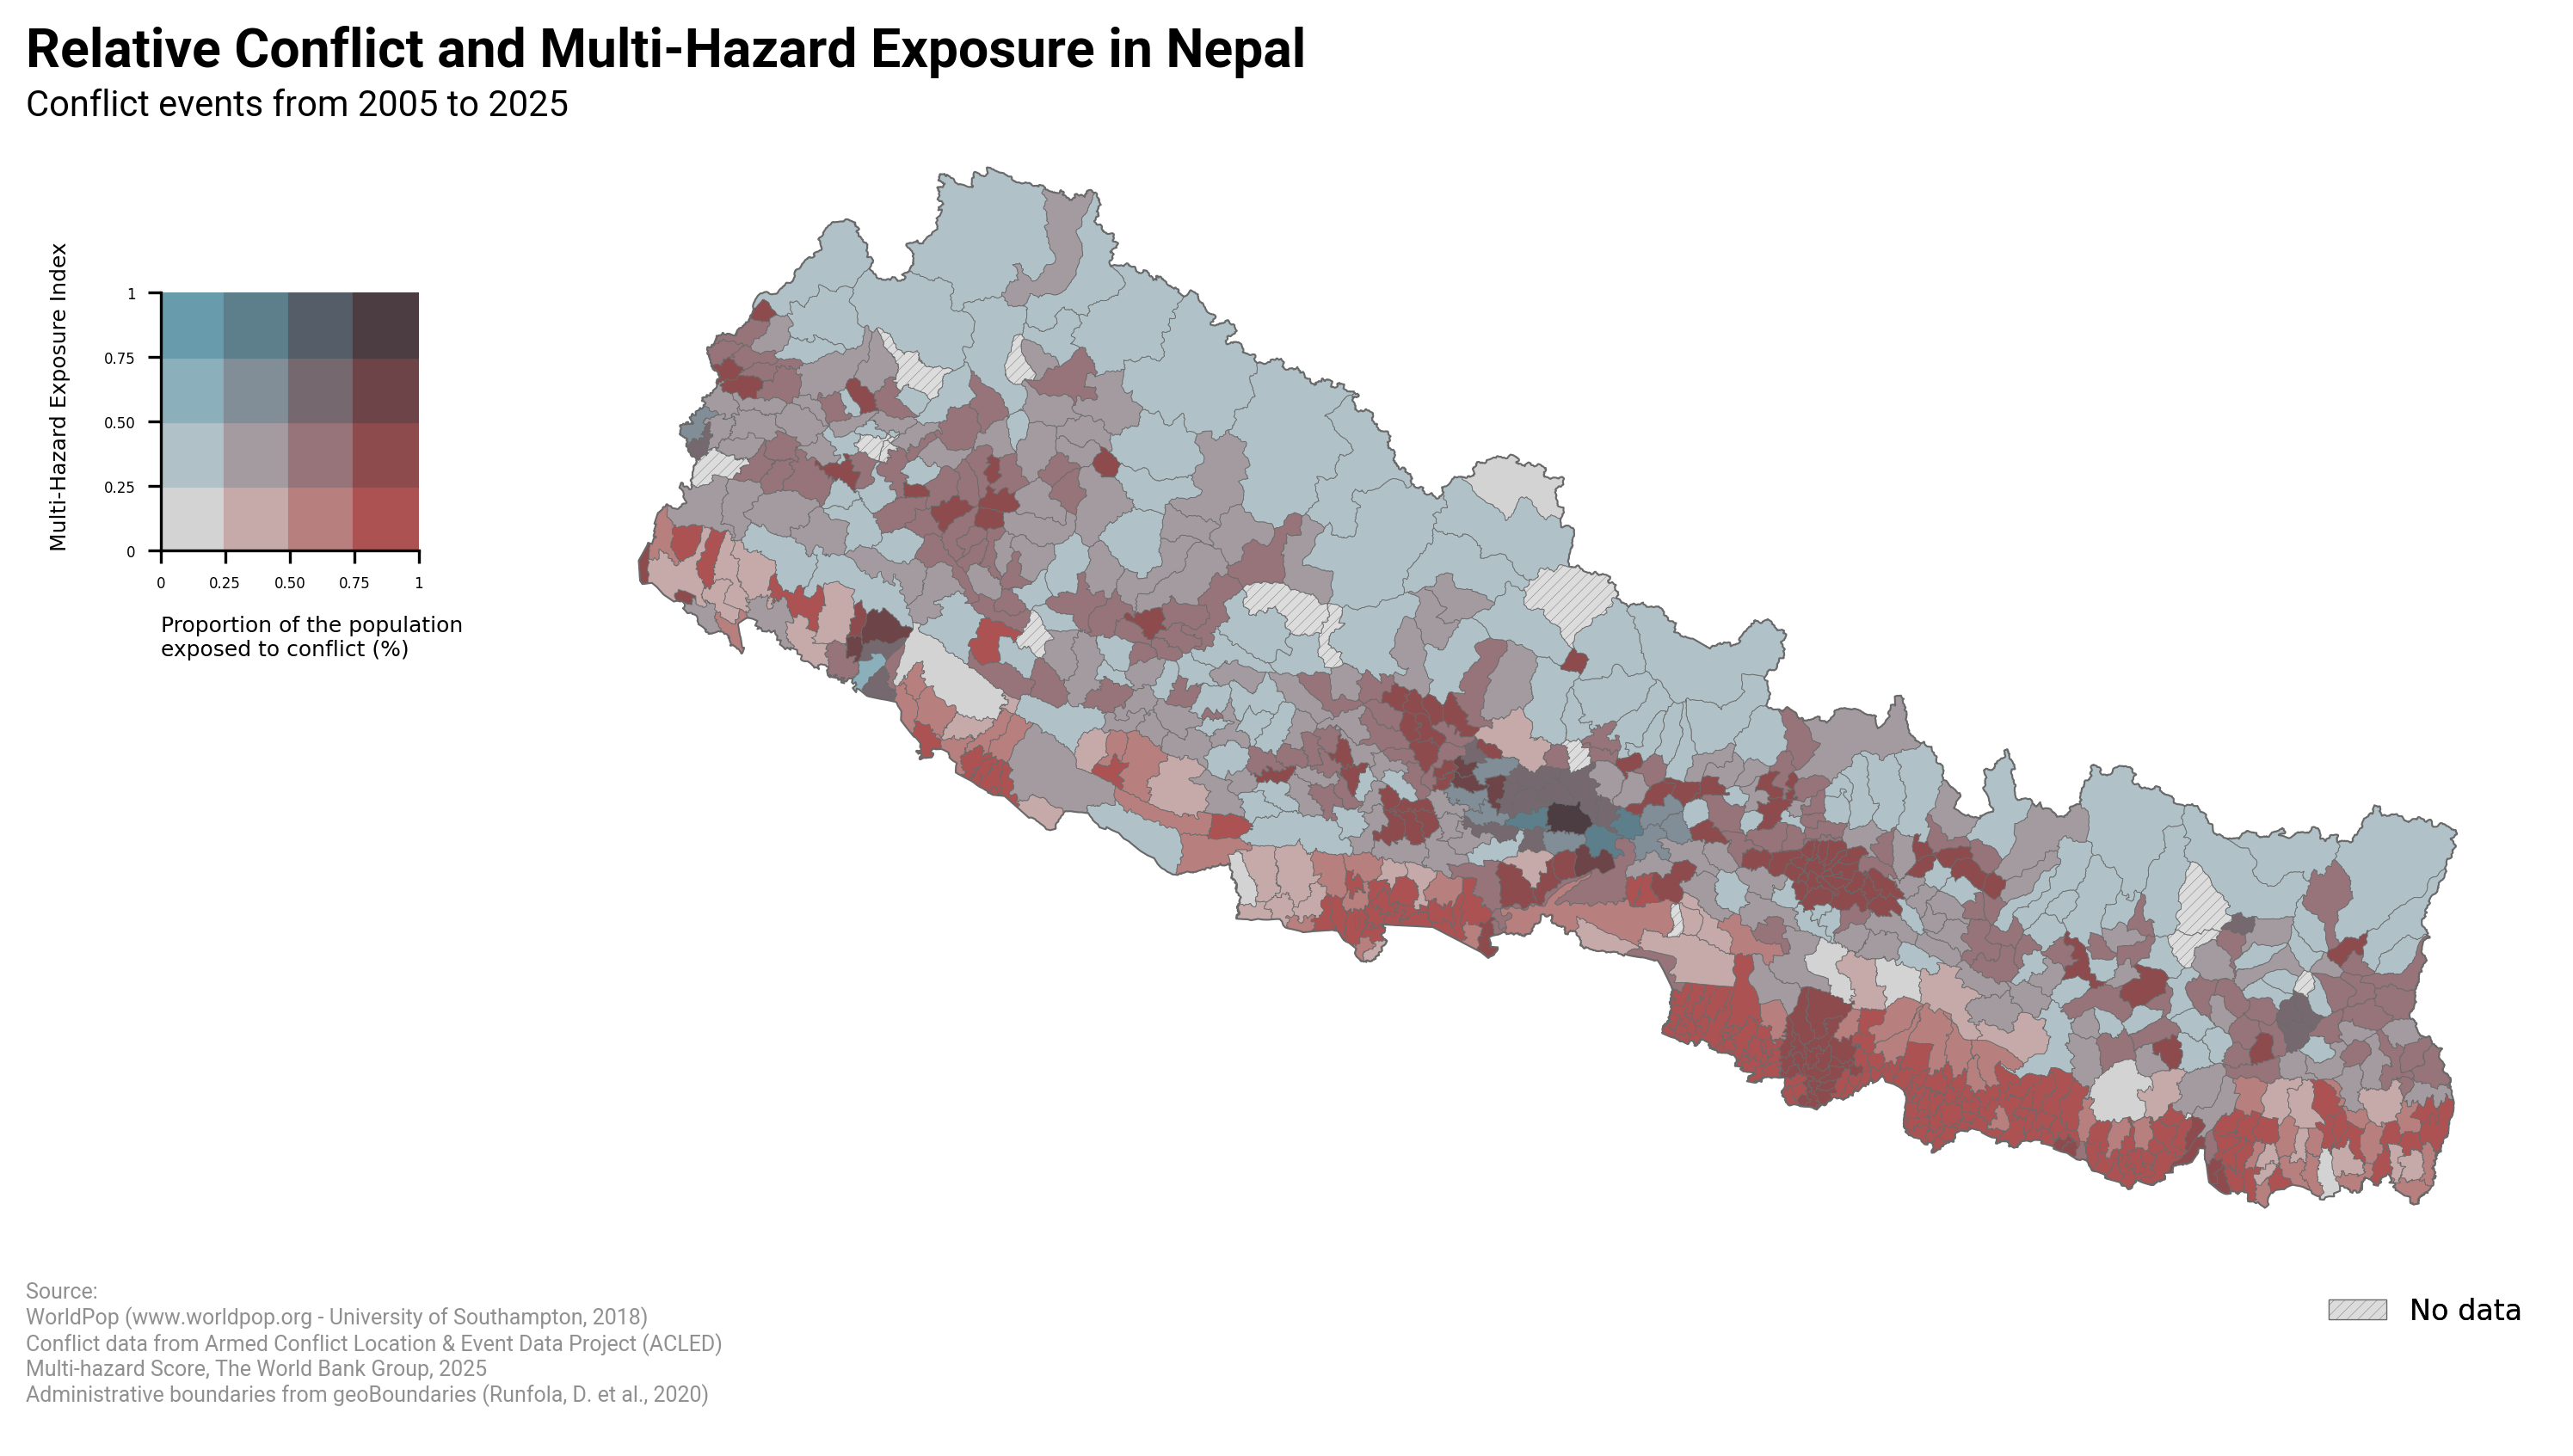

In [ ]:
# @markdown ### Plot Multi-hazard Conflict Exposure Bi-variate Map
conflict_exposure_source = "ACLED (WBG calculation)" # @param ["ACLED (WBG calculation)", "UCDP"]
conflict_exposure = "relative" # @param ["absolute", "relative"]

source = data_utils.get_conflict_source(dm, conflict_exposure_source)
conflict_exposure = data_utils.get_exposure(dm, conflict_exposure)

mhs_exposure = "relative" # @param ["relative", "intensity_weighted_relative"]
mhs_exposure = data_utils.get_exposure(dm, mhs_exposure)

hazard_category = "all" # @param ["all", "hydrological", "atmospheric", "geophysical", "biophysical"]

# @markdown ---
# @markdown ### Zoom to a specific region
zoom_to_region = False # @param {type: "boolean"}
adm_level = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_string = "Lumbini" # @param {type: "string"}
# @markdown ---

# @markdown ### Overlay points
overlay_points = False # @param {type: "boolean"}
clustering = False # @param {type: "boolean"}
clustering_distance = 50 # @param {type: "number"}
points = "ACLED" # @param ["ACLED", "UCDP", "OSM"]
points_column = "disorder_type" # @param ["disorder_type", "event_type", "type_of_violence", "sub_event_type", "osm_category"]
# @markdown ---

zoom_to = None
if zoom_to_region:
   zoom_to = {adm_level: adm_string}

ax, x = geoplot.plot_bivariate_choropleth(
    var1=f"{source}_{conflict_exposure}",
    var2=f"mhs_{hazard_category}_{dm.asset}_{mhs_exposure}",
    var1_bounds=[0, 1],
    var2_bounds=[0, 1],
    binning="equal_intervals",
    kwargs={
        "legend_fontsize": 4,
        "edgecolor": "dimgray",
        "linewidth": 0.2
    },
    zoom_to=zoom_to
);

if overlay_points:
  geoplot.plot_points(
      points_column,
      dataset=points.lower(),
      clustering=clustering,
      kwargs={
          "alpha": 1,
          "legend_y": 0.30,
          "markerscale": 1,
          "cmap": "tab10"
      },
      zoom_to=zoom_to,
      distance=clustering_distance,
      ax=ax, xpos=x,
  );

## Interactive Mapping with Folium

In [ ]:
m = geoplot.plot_folium(
    adm_level=adm_level,
    var="mhs_all_wbg_acled_worldpop_exposure_relative",
    kwargs={"zoom_start": 9}
)
m

In [ ]:
 m.save("folium.html")